In [58]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
from metrics import cindex
import time

# I - Let's download and visualize the data

## I - A ) Download directories and labels

In [2]:
train_root = 'training_data'
test_root = 'test_data'
archive = np.load(os.path.join(test_root,'images/patient_000.npz'))
scan = archive['scan'] # a np.array
mask = archive['mask'] # a np.array
assert scan.shape==mask.shape

In [186]:
training_labels = pd.read_csv('training_labels.csv', index_col=0)
training_labels.head()

,SurvivalTime,Event
PatientID,,
202,1378,0
371,379,1
246,573,1
240,959,0
284,2119,0


Let's visualize how should an output file look like :

In [233]:
rdm_sub = pd.read_csv('random_submission.csv', index_col=0)
rdm_sub.head()

,SurvivalTime,Event
PatientID,,
13,788.417673,NaN
155,427.650092,NaN
404,173.587222,NaN
407,389.877973,NaN
9,1580.767244,NaN


In [5]:
training_features_path = os.path.join(train_root,'features')
clinical_data = pd.read_csv(os.path.join(training_features_path, 'clinical_data.csv'), index_col=0)
radiomics = pd.read_csv(os.path.join(training_features_path, 'radiomics.csv'), index_col=0, skiprows=[0,2])
radiomics.index.name = 'PatientID'

# First, as we will use the origin of the data, we transform its values to make it an interger
try:
    clinical_data['SourceDataset'] = clinical_data['SourceDataset'].apply(lambda x: int(x[-1]))
except:
    pass
#clinical_data.head() # SourceDataset, Nstage

data = pd.concat([training_labels, clinical_data, radiomics], axis=1)

In [6]:
data.head()

,SurvivalTime,Event,Histology,Mstage,Nstage,SourceDataset,Tstage,age,original_shape_Compactness1,original_shape_Compactness2,...,original_glrlm_LongRunEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_RunLengthNonUniformity,original_glrlm_RunPercentage,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis
PatientID,,,,,,,,,,,,,,,,,,,,,
202,1378,0,Adenocarcinoma,0,0,2,2,66.0000,0.027815,0.274892,...,1.457980,555.378594,14592.303727,0.891330,0.003562,954.749135,0.003384,851.987373,0.004444,1651.710761
371,379,1,large cell,0,2,1,4,64.5722,0.023015,0.188210,...,2.512125,1766.619373,22881.932686,0.766032,0.002246,1092.823724,0.002069,884.838627,0.003633,3386.995589
246,573,1,squamous cell carcinoma,0,3,1,2,66.0452,0.027348,0.265740,...,4.096838,3462.816344,18773.106002,0.644554,0.001880,878.989601,0.001635,634.910036,0.004869,4232.418080
240,959,0,nos,0,2,1,3,59.3566,0.026811,0.255406,...,1.824328,683.869792,7978.285176,0.828138,0.002855,907.045929,0.002680,774.885387,0.003901,1844.746046
284,2119,0,squamous cell carcinoma,0,3,1,4,71.0554,0.023691,0.199424,...,2.652580,962.094760,7520.054910,0.734898,0.006710,1513.420445,0.004704,1197.140900,0.023273,4444.272812


Let's also create the test dataset :

In [187]:
test_features_path = os.path.join(test_root,'features')
test_clinical_data = pd.read_csv(os.path.join(test_features_path, 'clinical_data.csv'), index_col=0)
test_radiomics = pd.read_csv(os.path.join(test_features_path, 'radiomics.csv'), index_col=0, skiprows=[0,2])
test_radiomics.index.name = 'PatientID'

# First, as we will use the origin of the data, we transform its values to make it an interger
try:
    test_clinical_data['SourceDataset'] = test_clinical_data['SourceDataset'].apply(lambda x: int(x[-1]))
except:
    pass
#clinical_data.head() # SourceDataset, Nstage

test_dataset = pd.concat([test_clinical_data, test_radiomics], axis=1)

In [189]:
test_dataset.head()

,Histology,Mstage,Nstage,SourceDataset,Tstage,age,original_shape_Compactness1,original_shape_Compactness2,original_shape_Maximum3DDiameter,original_shape_SphericalDisproportion,...,original_glrlm_LongRunEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_RunLengthNonUniformity,original_glrlm_RunPercentage,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis
PatientID,,,,,,,,,,,,,,,,,,,,,
13,nos,0,0,1,4,44.3970,0.028885,0.296451,106.901824,1.499738,...,5.786839,21219.447221,64776.697579,0.567095,0.001493,808.353957,0.001094,554.111998,0.007535,4654.031976
155,adenocarcinoma,0,3,1,1,63.3183,0.031948,0.362660,18.814888,1.402276,...,1.160397,25.291608,795.675280,0.953475,0.011646,548.964573,0.010836,529.644029,0.015633,639.621963
404,large cell,0,2,1,2,64.7255,0.015999,0.090945,105.080921,2.223687,...,4.064385,3225.808332,14007.509285,0.644247,0.001171,1600.952265,0.001003,1181.377774,0.003027,7156.937667
407,nos,0,0,1,2,65.3635,0.031358,0.349373,46.968074,1.419832,...,2.902586,1147.928170,6094.805584,0.711467,0.002104,1533.217788,0.001900,1182.876363,0.003685,4776.549408
9,Adenocarcinoma,0,0,2,2,50.0000,0.017815,0.112759,56.542020,2.069901,...,1.195505,652.071367,15924.101510,0.942025,0.019281,344.205786,0.018221,331.901212,0.024175,400.015847


---

## I - B ) Have a look at the images

In [7]:
# How is the image encoded ?
print(np.unique(scan))

[-1023 -1021 -1019 ...   511   550   561]


> The images are encoded in 10 bits, however to visualize it we need to have pixel values in [0, 255] (we use a min-max transformation).

> Actually, during the process we came across the value of 2105 in the scan ! Thus a transormation min/max can be wiser even though it changes the initial values of the scans (meaning that 2 same values from 2 different images can result in the same value after rescaling them).

In [8]:
def to_pixel_values(scan):
    """
    From a scan encoded in [-1024, 1024], we want to rescale it to [0, 255] in order to plot it.
    """
    max_value = np.max(scan) # 1023
    min_value = np.min(scan) # -1024

    new_scan = 255*(1.*scan-min_value)/(max_value-min_value)
    new_scan = new_scan.astype(int)
    
    return new_scan

In [9]:
import io
import base64
from IPython.display import HTML
import skvideo.io

# display videos
def display_videos(name):
    """
    Input: str
        The name of the video to show in this notebook.
    """
    video = io.open(name, 'r+b').read()
    encoded = base64.b64encode(video)
    return '''<video width="320" height="240" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))

In [10]:
print('Here is the CT SCAN :')
skvideo.io.vwrite('CT_SCAN.mp4', to_pixel_values(scan))
HTML(display_videos('CT_SCAN.mp4'))

Here is the CT SCAN :


In [11]:
print('Here is the mask of this CT SCAN :')
skvideo.io.vwrite('MASK.mp4', mask.astype(int)*255)
HTML(display_videos('MASK.mp4'))

Here is the mask of this CT SCAN :


In [12]:
print('Here is the masked CT SCAN on which we only visualize the tumor cell :')
skvideo.io.vwrite('MASKED_IMG.mp4', to_pixel_values(scan)*mask.astype(int))
HTML(display_videos('MASKED_IMG.mp4'))

Here is the masked CT SCAN on which we only visualize the tumor cell :


Do we have masks for all test images ? 

In [13]:
for root in [train_root, test_root]:
    for img_path in os.listdir(os.path.join(root,'images')):
        archv = np.load(os.path.join(os.path.join(root,'images'),img_path))
        try :
            archv['mask']
        except:
            print('No masks for {}'.format(img_path))

As we have all masks, we won't train a NN to find them on images and no need to use an attention based NN since we already have the masks (first assumption, we might come back to this later). If we didn't, we could have used a RetinaNet for instance.

---

## I - C ) Survival curves and dependencies

Many considerations could be added in this part and if I had more time and worked on a totally new project with data never seen before, I would have proposed a thorough analysis for this part. Nevertheless, I will try to print some important figures and try to get to know the dataset a little bit.

A very first thing to do is to clean up the `Histology` column :

In [14]:
### What are the current classes ?
known_classes = np.unique(data['Histology'].astype(str))
# > ['Adenocarcinoma', 'NSCLC NOS (not otherwise specified)',
#       'Squamous cell carcinoma', 'adenocarcinoma', 'large cell', 'nan',
#       'nos', 'squamous cell carcinoma']

# Let's manually clean it :
histo_array = np.array(data['Histology'].astype(str)).copy()
for idx in range(len(histo_array)):
    if histo_array[idx]=='adenocarcinoma' or histo_array[idx]=='Adenocarcinoma':
        histo_array[idx] = 'Ade'
    elif histo_array[idx]=='NSCLC NOS (not otherwise specified)' or histo_array[idx]=='nan' \
                                                                or histo_array[idx]=='nos':
        histo_array[idx] = 'mix'
    elif histo_array[idx]=='Squamous cell carcinoma' or histo_array[idx]=='squamous cell carcinoma':
        histo_array[idx] = 'SCC'
    elif histo_array[idx]=='large cell':
        histo_array[idx] = 'LCC'
        
values, proportions = np.unique(histo_array,return_counts=True)
for idx, value in enumerate(values):
    print('Number of {} in the dataset : {},\t proportion = {:.2f}%'.format(value, proportions[idx],
                                                             100*float(proportions[idx])/np.sum(proportions)))
    
data['Histology'] = pd.DataFrame(histo_array, columns=['Histology'], index=data.index)

Number of Ade in the dataset : 101,	 proportion = 33.67%
Number of LCC in the dataset : 61,	 proportion = 20.33%
Number of SCC in the dataset : 78,	 proportion = 26.00%
Number of mix in the dataset : 60,	 proportion = 20.00%


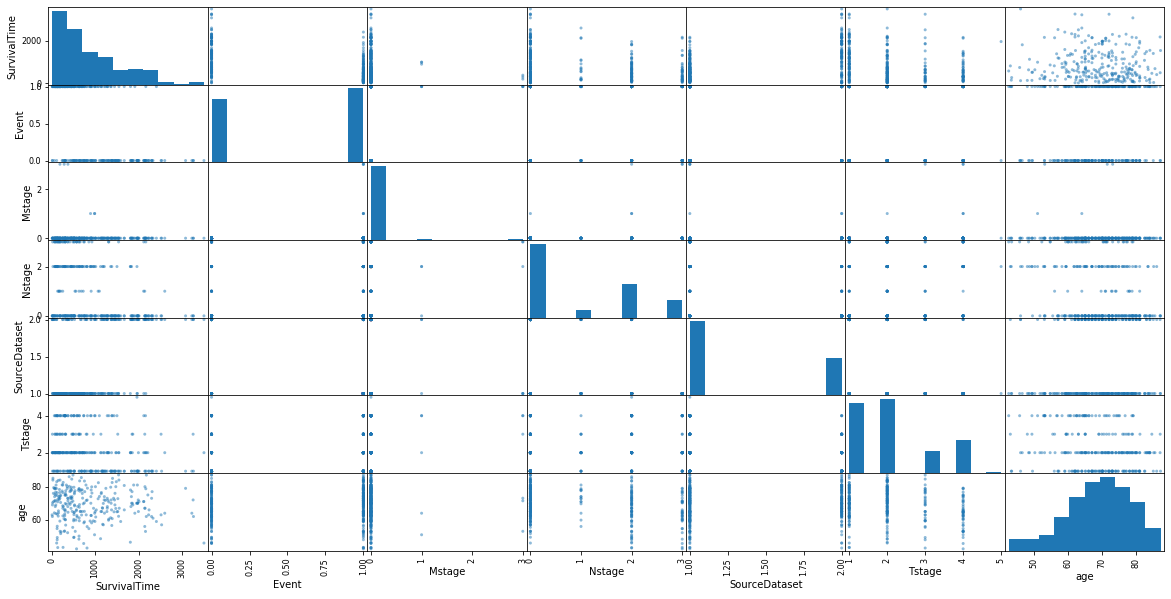

In [15]:
from pandas.plotting import scatter_matrix
attributes = ['SurvivalTime', 'Event', 'Mstage', 'Nstage','SourceDataset', 'Tstage', 'age']
scatter_matrix(data[attributes], figsize=(20,10));

> We don't visualize many impressive correlations, but as we want to predict `SurvivalTime`, `N Stage` seems to have a high impact. Additionnaly, `N Stage`and `T stage` seem to have pretty much the same distributions (Then why do we take `N Stage` in the predictions insted of `T Stage` ?).

Then, let's have a look at the proportion of patients that went off the study :

In [16]:
present_patients = np.array(data['Event'])
values = np.unique(present_patients,return_counts=True)[1]
proportions = 100*values/np.sum(values)
print('{} patients escaped the study   : proportion of {}%'.format(values[0],proportions[0]))
print('{} patients stayed in the study : proportion of {}%'.format(values[1],proportions[1]))

138 patients escaped the study   : proportion of 46.0%
162 patients stayed in the study : proportion of 54.0%


> Interesting for later considerations to notice that this is pretty balanced.

Let's plot Kaplan Meier survival curves :

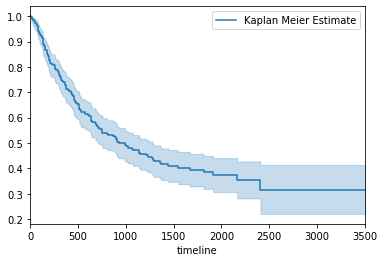

In [17]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter() 
kmf.fit(data['SurvivalTime'], data['Event'], label='Kaplan Meier Estimate')
kmf.plot();

> This is somehow a standard survival curve...

We also want to have an idea of the importance of the histology in the survival predictions :

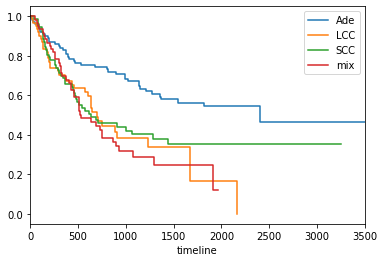

In [18]:
kmf = KaplanMeierFitter()
histo_data = data[data['Histology']=='Ade']
kmf.fit(histo_data['SurvivalTime'], histo_data['Event'], label='Ade')
a = kmf.plot(ci_show=False)
for histo_class in ['LCC','SCC','mix']:
    histo_data = data[data['Histology']==histo_class]
    kmf.fit(histo_data['SurvivalTime'], histo_data['Event'], label=histo_class)
    kmf.plot(ax=a,ci_show=False)

> Thus, it seems that depending on the `Histology`, a patient doesn't have the same survival properties. This might actually be of great interest when we will try to train our own model. Indeed, training it to predict the `Histology` might not infer in a too useless representation of the images for the survival prediction made by a cox model.

> Moreover, according to these curves we might be able to create a correct encoding for these text values. A common issue in text encoding is that 2 values encoded with the numbers 1 and 2 will be understood by the model as being closer to each other than 2 values encoded 1 and 4. Thus we could use OneHotEncoding, or according to the curves presented above, we can say that $$[Ade, LCC, SCC, mix]\ \ ->  [0, 2, 1, 3]$$ could be a good encoding since the curve are ranked in this order.

Let's encode our data :

In [19]:
# Let's manually encode it :
histo_array = np.array(data['Histology']).copy()
for idx in range(len(histo_array)):
    if histo_array[idx]=='Ade':
        histo_array[idx] = 0
    elif histo_array[idx]=='LCC':
        histo_array[idx] = 2
    elif histo_array[idx]=='SCC':
        histo_array[idx] = 1
    elif histo_array[idx]=='mix':
        histo_array[idx] = 3
        
data['Histology'] = pd.DataFrame(histo_array, columns=['Histology'], index=data.index).astype(int)

Apply this to `test_dataset` as well :

In [191]:
# Let's manually clean it :
histo_array = np.array(test_dataset['Histology'].astype(str)).copy()
for idx in range(len(histo_array)):
    if histo_array[idx]=='adenocarcinoma' or histo_array[idx]=='Adenocarcinoma':
        histo_array[idx] = 'Ade'
    elif histo_array[idx]=='NSCLC NOS (not otherwise specified)' or histo_array[idx]=='nan' \
                                                                or histo_array[idx]=='nos':
        histo_array[idx] = 'mix'
    elif histo_array[idx]=='Squamous cell carcinoma' or histo_array[idx]=='squamous cell carcinoma':
        histo_array[idx] = 'SCC'
    elif histo_array[idx]=='large cell':
        histo_array[idx] = 'LCC'
        
values, proportions = np.unique(histo_array,return_counts=True)
for idx, value in enumerate(values):
    print('Number of {} in the test dataset : {},\t proportion = {:.2f}%'.format(value, proportions[idx],
                                                             100*float(proportions[idx])/np.sum(proportions)))
    
test_dataset['Histology'] = pd.DataFrame(histo_array, columns=['Histology'], index=test_dataset.index)

# Let's manually encode it :
histo_array = np.array(test_dataset['Histology']).copy()
for idx in range(len(histo_array)):
    if histo_array[idx]=='Ade':
        histo_array[idx] = 0
    elif histo_array[idx]=='LCC':
        histo_array[idx] = 2
    elif histo_array[idx]=='SCC':
        histo_array[idx] = 1
    elif histo_array[idx]=='mix':
        histo_array[idx] = 3
        
test_dataset['Histology'] = pd.DataFrame(histo_array, columns=['Histology'], index=test_dataset.index).astype(int)

Number of Ade in the test dataset : 36,	 proportion = 28.80%
Number of LCC in the test dataset : 32,	 proportion = 25.60%
Number of SCC in the test dataset : 31,	 proportion = 24.80%
Number of mix in the test dataset : 26,	 proportion = 20.80%


We observe that at least the proportions seem to be pretty much the same (except for a small difference for the LCC...)

---
---
---

# II - Use a cox model to fit the data and get predictions

In [20]:
from lifelines import CoxPHFitter
import sksurv
from sksurv.linear_model import CoxPHSurvivalAnalysis

## II - A ) Use the cox model from scikit-survival library

### II - A - 1) Without using the images -> try to get the results presented on the web page of the challenge.

Let's know train a simple model only using the 53 features and clinical data :

In [21]:
clinical_data.head() # SourceDataset, Nstage

,Histology,Mstage,Nstage,SourceDataset,Tstage,age
PatientID,,,,,,
202,Adenocarcinoma,0,0,2,2,66.0000
371,large cell,0,2,1,4,64.5722
246,squamous cell carcinoma,0,3,1,2,66.0452
240,nos,0,2,1,3,59.3566
284,squamous cell carcinoma,0,3,1,4,71.0554


From this one, we will select the following columns based on the indication to reproduce the results presented at https://challengedata.ens.fr/participants/challenges/33/ :
- SourceDataset
- Nstage

In [22]:
radiomics.head()

,original_shape_Compactness1,original_shape_Compactness2,original_shape_Maximum3DDiameter,original_shape_SphericalDisproportion,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_Energy,original_firstorder_Entropy,...,original_glrlm_LongRunEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_RunLengthNonUniformity,original_glrlm_RunPercentage,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis
PatientID,,,,,,,,,,,,,,,,,,,,,
202,0.027815,0.274892,48.559242,1.537964,0.650210,5431.333210,0.275228,19786.0,3.942944e+09,5.138062,...,1.457980,555.378594,14592.303727,0.891330,0.003562,954.749135,0.003384,851.987373,0.004444,1651.710761
371,0.023015,0.188210,75.703368,1.744961,0.573079,10369.568729,0.240727,43168.0,3.122890e+09,4.461054,...,2.512125,1766.619373,22881.932686,0.766032,0.002246,1092.823724,0.002069,884.838627,0.003633,3386.995589
246,0.027348,0.265740,70.434367,1.555420,0.642913,10558.818691,0.200766,52655.0,1.059535e+09,3.437111,...,4.096838,3462.816344,18773.106002,0.644554,0.001880,878.989601,0.001635,634.910036,0.004869,4232.418080
240,0.026811,0.255406,46.818800,1.576120,0.634469,4221.412123,0.323878,13074.0,6.583324e+08,4.352564,...,1.824328,683.869792,7978.285176,0.828138,0.002855,907.045929,0.002680,774.885387,0.003901,1844.746046
284,0.023691,0.199424,53.795911,1.711620,0.584242,5295.900331,0.327241,16237.0,8.072532e+08,4.055700,...,2.652580,962.094760,7520.054910,0.734898,0.006710,1513.420445,0.004704,1197.140900,0.023273,4444.272812


From this one, we will select the following columns based on the indication to reproduce the results presented at https://challengedata.ens.fr/participants/challenges/33/ :
- original_shape_Sphericity
- original_shape_SurfaceVolumeRatio
- original_shape_Maximum3DDiameter
- original_glcm_JointEntropy
- original_glcm_Idm : inverse different moment
- original_glcm_Id : inverse difference

First, let's create both train and validation datasets. Quick remark : cross-validation is mainly used in order to select the best hyperparameters, but in for now we use thr cox model from lifelines which can't be tuned... Thus creating cross validation splits isn't relevant and working with train/val is enough.

In [373]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2,random_state=56)
splitting = split.split(data, data['Event'])#, data['SourceDataset'].values) 
# On which column do you want to keep the same distribution in both training and validation
### This way, we can try to prevent the model to be biased by the hospital origin,
### and more precisely the acquisition method.

for train, val in splitting:
    data_train = data.iloc[train]
    data_val = data.iloc[val]
    
data_train_copy = data_train.copy()
data_val_copy = data_val.copy()

**Start using lifelines function :**

In [203]:
def normalize_data(data_train, data_val, data_test=None):
    """
    Normalize each column applying the following pipeline : 
     - get the transformation coefficient on the training_set.
     - apply this very transformation to both data_train and data_val.
     - return the normalized datasets.
    """
    for col_name in data_train.drop(['SurvivalTime', 'Event'], axis=1).columns:
        mu, sigma = np.mean(data_train[col_name].values), np.std(data_train[col_name].values)
        data_train.loc[:,col_name] = (data_train[col_name].values - mu)/sigma

        # Then apply this very transformation to the validation data and test data :
        data_val.loc[:,col_name] = (data_val[col_name].values - mu)/sigma
        try: # we only change it if we pass a data_test
            data_test.loc[:,col_name] = (data_test[col_name].values - mu)/sigma
        except:
            pass
    
    try:
        if data_test:
            return data_train, data_val, data_test
        else:
            return data_train, data_val
    except: # Then data_test exists
        return data_train, data_val, data_test

def predict_lifelines_cox(data_train, data_val, features_names, normalize=False, show_summary=True):
    """
    Use lifelines' cox model to predict survival of patients based on specific features.
    
    Input:
        data_train: pd.DataFrame
            The training dataset. Must contain 'SurvivalTime', 'Event' and features_names in its columns.
        data_val: pd.DataFrame
            The validation dataset. Must contain 'SurvivalTime', 'Event' and features_names in its columns.
        feature_names: list
            A list of feature names to consider in the cox model.
        normalize: boolean
            Whether to normalize data or not.
        show_summary: boolean
            Whether to show the summary or not. This summary contains informations on which feature is important
            for the model, as well as the training results (CI score).
            
    Output:
        a tuple containing the cox model, data_train and data_val
    """
    data_train = data_train[features_names]
    data_val = data_val[features_names]
    
    if normalize:
        data_train, data_val = normalize_data(data_train, data_val)
        
    ### Training Phase and predictions on the validation dataset
    # Let's try to use a simple cox model
    cph = CoxPHFitter()
    cph.fit(data_train, 'SurvivalTime', event_col='Event')
    if show_summary:
        cph.print_summary() # Prints training results and how important is each feature
    #cph.plot() # Plots the importance of each feature
    #cph.predict_survival_function(data[['SurvivalTime', Event', 'Mstage',
    #                                        'Nstage', 'Tstage']].iloc[5:10,2:]).plot()
    
    pred = cph.predict_expectation(data_val.drop(['SurvivalTime', 'Event'], axis=1))
    pred.columns = ['SurvivalTime']
    pred.index.name = 'PatientID'
    pred = pd.concat([pred, data_val['Event']], axis=1)
    
    result = cindex(data_val[['SurvivalTime', 'Event']], pred)
    print('Performance on the validation set (CI) : {:.3f}'.format(result))

    return (cph, data_train, data_val, result)

Have an insight of the bias in data origin of our model :

In [25]:
prop_HP1 = len(data['SourceDataset'][data['SourceDataset']==1])/len(data)
print('{:.3f} %% of the data come from Hospital 1.'.format(prop_HP1))
prop_HP1 = len(data_train['SourceDataset'][data_train['SourceDataset']==1])/len(data_train)
print('{:.3f} %% of the data come from Hospital 1.'.format(prop_HP1))
prop_HP1 = len(data_val['SourceDataset'][data_val['SourceDataset']==1])/len(data_val)
print('{:.3f} %% of the data come from Hospital 1.'.format(prop_HP1))

0.663 %% of the data come from Hospital 1.
0.671 %% of the data come from Hospital 1.
0.633 %% of the data come from Hospital 1.


*NB, normalizing the data doesn't seem to have a huge impact here. We will consider this when implementing our own verison of a cox model, which will possibly use an SVM (requires data to be normalized).*

In [26]:
features_names = ['SurvivalTime', 'Event', 'Histology', 'SourceDataset', 'Nstage', 
                  'original_shape_Sphericity', 
                  'original_shape_Maximum3DDiameter',
                  'original_glcm_JointEntropy',
                  'original_shape_SurfaceVolumeRatio', 
                  'original_glcm_Idm',
                  'original_glcm_Id']

(cph, _, _, _) = predict_lifelines_cox(data_train, data_val, features_names)

n=240, number of events=130

                                      coef         exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95   
Histology                           0.0880            1.0920    0.1016  0.8667 0.3861     -0.1110      0.2871   
SourceDataset                      -0.5870            0.5560    0.3892 -1.5081 0.1315     -1.3498      0.1759   
Nstage                              0.1856            1.2039    0.0795  2.3358 0.0195      0.0299      0.3413  *
original_shape_Sphericity           2.8294           16.9352    1.5611  1.8124 0.0699     -0.2303      5.8891  .
original_shape_Maximum3DDiameter    0.0109            1.0110    0.0046  2.3603 0.0183      0.0018      0.0199  *
original_glcm_JointEntropy          0.6011            1.8242    0.2968  2.0252 0.0429      0.0194      1.1829  *
original_shape_SurfaceVolumeRatio   1.5646            4.7810    1.2317  1.2703 0.2040     -0.8495      3.9788   
original_glcm_Idm                  26.5122 326673160366.2231   21.4

Given the concordance on the training set (0.705) and the one on the validation set (0.668), we probably overfit a bit... Let's consider fewer features based on their respective importance :

In [27]:
features_names = ['SurvivalTime', 'Event', 'Nstage', 
                  'original_shape_Maximum3DDiameter','original_glcm_JointEntropy',
                  'original_shape_Sphericity']

(cph, _, _, _) = predict_lifelines_cox(data_train, data_val, features_names)

n=240, number of events=130

                                    coef  exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95     
Nstage                            0.2647     1.3030    0.0776  3.4084 0.0007      0.1125      0.4168  ***
original_shape_Maximum3DDiameter  0.0093     1.0093    0.0041  2.2713 0.0231      0.0013      0.0173    *
original_glcm_JointEntropy       -0.1180     0.8887    0.0624 -1.8895 0.0588     -0.2404      0.0044    .
original_shape_Sphericity         2.3978    10.9991    1.2579  1.9062 0.0566     -0.0676      4.8633    .
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.687
Likelihood ratio test = 42.732 on 4 df, p=0.00000
Performance on the validation set (CI) : 0.641


> Unfortunately, we may not overfit this time, but we definitely lost information...

**Try out the scikit-survival function :** Indeed, lifelines only computes a standard linear regression in the cox model. Nevertheless, scikit-survival computes a ridge linear regression which is a bit better since it adds L2 regularization. But still not the best model...

In [28]:
def predict_sksurv_cox(data_train, data_val, features_names, alpha=1., normalize=False, display=True):
    """
    Use lifelines' cox model to predict survival of patients based on specific features.
    
    Input:
        data_train: pd.DataFrame
            The training dataset. Must contain 'SurvivalTime', 'Event' and features_names in its columns.
        data_val: pd.DataFrame
            The validation dataset. Must contain 'SurvivalTime', 'Event' and features_names in its columns.
        feature_names: list
            A list of feature names to consider in the cox model.
        alpha: float
            the regularization parameter of the ridge regression
        normalize: boolean
            Whether to normalize data or not.
        display: boolean
            Whether to show the summary or not. This summary contains informations on which feature is important
            for the model, as well as the training results (CI score).
            
    Output:
        a tuple containing the cox model, data_train and data_val
    """
    data_train = data_train[features_names]
    data_val = data_val[features_names]
    
    if normalize:
        data_train, data_val = normalize_data(data_train, data_val)
        
    ### Training Phase and predictions on the validation dataset
    # Let's try to use a simple cox model
    cph = CoxPHSurvivalAnalysis(alpha=alpha) #CoxPHFitter()
    
    events = np.array(data_train['Event'])
    SurvivalTime = np.array(data_train['SurvivalTime'])
    y_train = []
    for idx in range(len(data_train)):
        y_train.append((events[idx], SurvivalTime[idx]))
    y_train = np.array(y_train, dtype=[('Event', 'bool'), ('SurvivalTime', 'i4')])
    cph.fit(data_train.drop(['SurvivalTime','Event'],axis=1), y_train)
    
    train_result = cph.score(data_train.drop(['SurvivalTime','Event'],axis=1), y_train)
    
    events = np.array(data_val['Event'])
    SurvivalTime = np.array(data_val['SurvivalTime'])
    y_val = []
    for idx in range(len(data_val)):
        y_val.append((events[idx], SurvivalTime[idx]))
    y_val = np.array(y_val, dtype=[('Event', 'bool'), ('SurvivalTime', 'i4')])

    val_result = cph.score(data_val.drop(['SurvivalTime','Event'],axis=1), y_val)
    if display:
        print('Performance on the training set (CI) : {:.3f}'.format(train_result))
        print('Performance on the validation set (CI) : {:.3f}'.format(val_result))

    return (cph, data_train, data_val, val_result)

In [74]:
features_names = ['SurvivalTime', 'Event', 'Histology', 'SourceDataset', 'Nstage', 
                  'original_shape_Sphericity', 
                  'original_shape_Maximum3DDiameter',
                  'original_glcm_JointEntropy',
                  'original_shape_SurfaceVolumeRatio', 
                  'original_glcm_Idm',
                  'original_glcm_Id']

pd.set_option('mode.chained_assignment',None)
(cph, _, _, _) = predict_sksurv_cox(data_train, data_val, features_names, alpha=0.001, normalize=True)
# Note that in this case, it is important to normalize the data.

Performance on the training set (CI) : 0.704
Performance on the validation set (CI) : 0.668


In [75]:
features_names = ['SurvivalTime', 'Event', 'Nstage', 
                  'original_shape_Maximum3DDiameter','original_glcm_JointEntropy',
                  'original_shape_Sphericity']

(cph, _, _, _) = predict_sksurv_cox(data_train, data_val, features_names, alpha=1000, normalize=True)

Performance on the training set (CI) : 0.678
Performance on the validation set (CI) : 0.663


It seems that selecting features doesn't yield better results. Another way to do it more properly would be to use a Lasso regression (L1 loss) since it sends to shrink dramatically features coefficients to zero (in a better way than L0 loss, ie counting non-zero coefficients which tends to minimize the number of coefficients).

However, the feature selection and its robustness can be tuned by finding the proper alpha coefficient for the ridge regularization. Let's try to find it using a golden section search (instead of classical grid search or random search, it is a bit more fancy...)

**Choosing $\alpha$ :**

With a fixed number of evaluation $n$ we want to get closer to the maximum. 

To solve this probleme one can use the golden section search method.
We assume that the minimum of  $\alpha \mapsto CI(\alpha)$ for the validation test is between two value $a,b$ (one can just take a small enough value for $a$ and a high enough value for $b$). 


We initialize the algortihm with $\alpha_0 = a$ and $\alpha_3 = b$. 


At each iteration, we take 2 values for $\alpha$ subject to 
$$\alpha_1 = \alpha_0 + \frac{3- \sqrt{5}}{2}(\alpha_3 - \alpha_0)$$ 
$$\alpha_2 = \alpha_0 + \frac{\sqrt{5}-1}{2}(\alpha_3 - \alpha_0)$$ 
then if  $CI(\alpha_1)> CI(\alpha_2)$ : we iterate with $\alpha_3 :=\alpha_2$ else $\alpha_0 := \alpha_1$ 

Using this method, we approximate the optimal value for $\alpha$.

In [78]:
def golden_section_search(nb_blocks_range, train, val, features, tol=1e-8, it_max=100):
    nb_blocks0, nb_blocks3 = nb_blocks_range
    error = []
    nb_blocks = []
    golden_section_gamma = [(3 - np.sqrt(5))/2 , (np.sqrt(5)-1)/2]
    best_nb_blocks = {}
    it = 0
    converged = False
    while not converged and (it < it_max):
        it=it+1
        nb_blocks1 = int(nb_blocks0 + golden_section_gamma[0] * (nb_blocks3 - nb_blocks0))
        nb_blocks2 = int(nb_blocks0 + golden_section_gamma[1] * (nb_blocks3 - nb_blocks0))

        cph1, _, _, val_error_1 = predict_sksurv_cox(train, val, features, alpha=nb_blocks1,
                                                     normalize=True, display=False)
        nb_blocks.append(nb_blocks1)
        error.append(val_error_1)

        cph2, _, _, val_error_2 = predict_sksurv_cox(train, val, features, alpha=nb_blocks2,
                                                     normalize=True, display=False)
        nb_blocks.append(nb_blocks2)
        error.append(val_error_2)

        converged = (abs(val_error_2 - val_error_1)<tol)
        if val_error_1 > val_error_2 : 
            nb_blocks0, nb_blocks3 = nb_blocks0, nb_blocks2
        else: 
            nb_blocks0, nb_blocks3 = nb_blocks1, nb_blocks3
    if converged :
        print('optimal value reached for : nb_blocks = {:.2e}'.format(nb_blocks1))
    end = time.time()

    _, _, _, _ = predict_sksurv_cox(train, val, features, alpha=nb_blocks1,
                                    normalize=True, display=True)

In [79]:
features_names = ['SurvivalTime', 'Event', 'Histology', 'SourceDataset', 'Nstage', 
                  'original_shape_Sphericity', 
                  'original_shape_Maximum3DDiameter',
                  'original_glcm_JointEntropy',
                  'original_shape_SurfaceVolumeRatio', 
                  'original_glcm_Idm',
                  'original_glcm_Id']

golden_section_search(nb_blocks_range=[1e-4,1e3], train=data_train, val=data_val, features=features_names,
                      tol=1e-6, it_max=100)

optimal value reached for : nb_blocks = 7.07e+02
Performance on the training set (CI) : 0.684
Performance on the validation set (CI) : 0.670


Well, it is a pretty good result and it converged very fast !! However, we don't reproduce the results presented on the web page of the challenge. Probably that training on the whole dataset and submitting on the online test would yield those results.

---

### II - A - 2 ) Feature extraction from a slice (2D) of the CT scans (resnet50, pretrained='imagenet')

First approach : take the slice containing the most information about the tumor and process this 2D image using a model pretrained on imagenet (able to recognize shapes and many images features).

In [81]:
def get_slice(scan, mask, slice_dim=None):
    """
    Using the mask volume of the scan, get the index of the slice containing most of the tumor.
    Then return the corresponding slice of the scan.
    
    slice_dim parameter allows to state a dimension along which to take the biggest slice. 
    If None, then thif function returns the biggest out of the 3 dimensions.
    """
    indexes = np.where(mask==1) # Get the indexes along each dimension of the mask
    nb_white_pixels = 0
    if slice_dim==None:
        for dim in range(len(mask.shape)):
            values = np.unique(indexes[dim], return_counts=True) 
            # This gives us the number of white pixels for each index in this dimension
            max_value = np.max(values[1]) # We get the maximal number of white pixels for the slices in this dimension
            if max_value > nb_white_pixels:
                nb_white_pixels = max_value
                preferred_slice = (dim, values[0][list(values[1]).index(max_value)])

    else:
        values = np.unique(indexes[slice_dim], return_counts=True) 
        # This gives us the number of white pixels for each index in this dimension
        max_value = np.max(values[1]) # We get the maximal number of white pixel for the slices in this dimension
        preferred_slice = (slice_dim, values[0][list(values[1]).index(max_value)])
                
                
    loc = [(0,92) for _ in range(preferred_slice[0])]
    loc += [(preferred_slice[1], preferred_slice[1]+1)]
    loc += [(0,92) for _ in range(2-preferred_slice[0])]
    slice_of_interest = scan[loc[0][0]:loc[0][1], loc[1][0]:loc[1][1], loc[2][0]:loc[2][1]]
    slice_of_interest = slice_of_interest.reshape(92,92)
    
    return slice_of_interest

For some patients, let's plot this biggest slice of the tumor (slice of interest) :

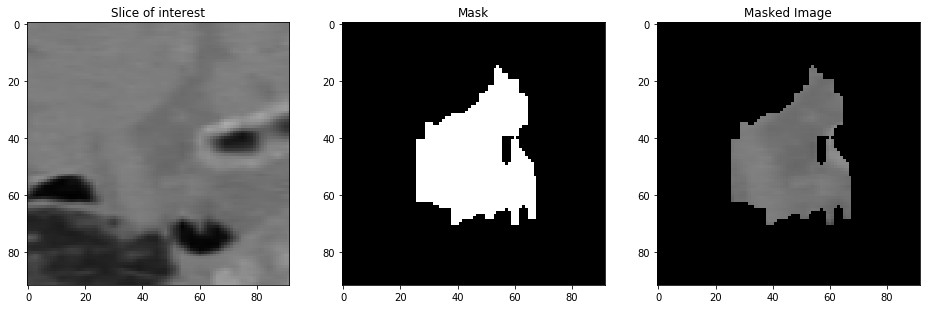

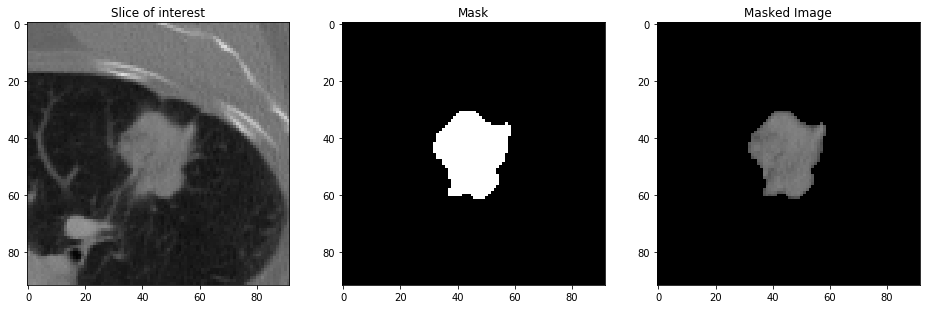

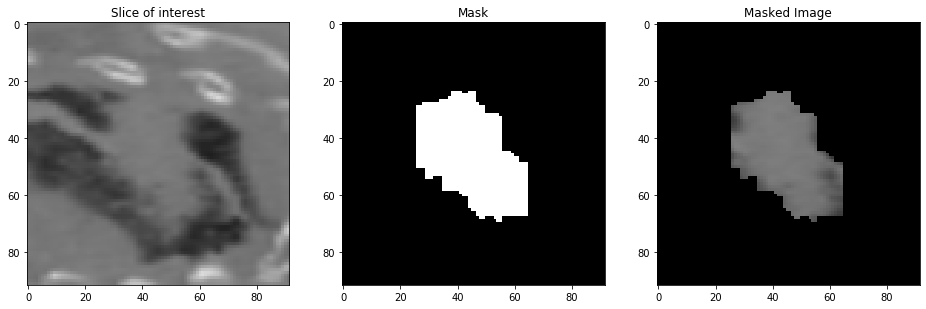

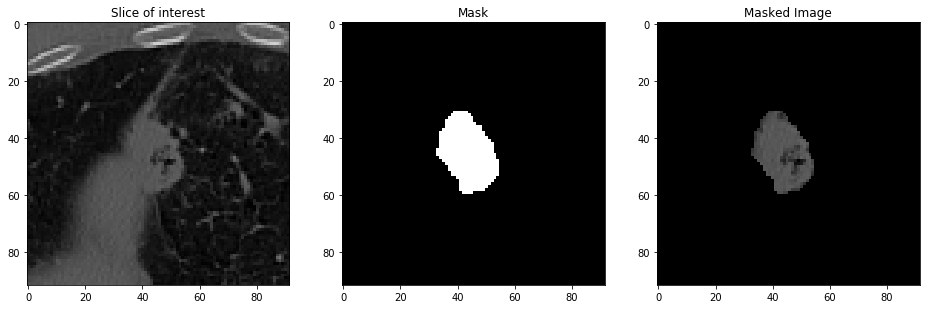

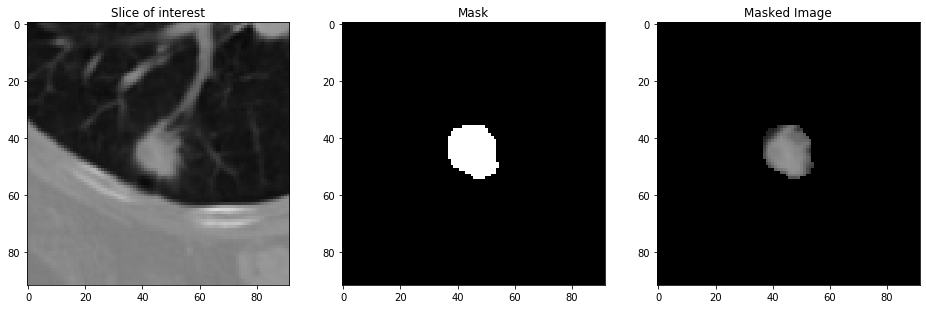

In [82]:
for patient_id in data_train.index[:5]:
    patient_id_str = '00'+str(patient_id)
    patient_id_str = patient_id_str[-3:]
    archive = np.load(os.path.join(train_root,'images/patient_{}.npz'.format(patient_id_str)))
    scan = archive['scan'] # a np.array
    mask = archive['mask'] # a np.array
    slice_of_interest = np.zeros((92,92,3))
    soi = get_slice(to_pixel_values(scan), mask)
    for dim in range(3):
        slice_of_interest[:,:,dim] = soi
    slice_of_interest = slice_of_interest.astype(int)
    
    plt.figure(figsize=(16,8))
    
    plt.subplot(131)
    plt.imshow(slice_of_interest)
    plt.title('Slice of interest')
    
    mask_of_interest = np.zeros((92,92,3))
    moi = get_slice(mask, mask)
    for dim in range(3):
        mask_of_interest[:,:,dim] = moi
    mask_of_interest = mask_of_interest.astype(int)
    
    plt.subplot(132)
    plt.imshow(mask_of_interest*255)
    plt.title('Mask')
    
    plt.subplot(133)
    plt.imshow(mask_of_interest*slice_of_interest)
    plt.title('Masked Image')
    
    plt.show()

Import the model using torch :

In [393]:
import torchvision.models as models
import torch.nn as nn
import torch
model = nn.Sequential(*list(models.resnet50('imagenet').children())[:-2])
# -2 instead of -1 will take off the last AvgPool2d if I want to play a bit.
model = model.double()

Get the extracted features for each patient and build a dataframe :

In [394]:
def feature_extractor(over_masked_images=False, slice_dim=None, normalization=False):
    features_img = np.ndarray((len(training_labels),2048))

    for idx, patient_id in tqdm.tqdm(enumerate(training_labels.index)):
        # Load the image
        patient_id_str = '00'+str(patient_id)
        patient_id_str = patient_id_str[-3:]
        archive = np.load(os.path.join(train_root,'images/patient_{}.npz'.format(patient_id_str)))
        scan = archive['scan'] # a np.array
        mask = archive['mask'] # a np.array

        try: # for some patients we don't have the mask though
            # Get the slice of interest
            img = get_slice(scan, mask, slice_dim)
            img = to_pixel_values(img)
            if over_masked_images:
                masked_slice = get_slice(mask, mask)
                img *= masked_slice.astype(int)

        except: # For images for which we don't have any masks, we need to rethink our approach
            #print('An issue has occured for patient {}'.format(patient_id))
            ### Output : Patients 327, 256, 3, 391, 263 have issues.
            img = np.zeros((92,92))
            
        # Extract features from it using Resnet50
        img_bgr = np.zeros((1, 3, 92, 92))
        if normalization:
            # Concerning the normalization, one can either do the following or simply divide by 255
            mean = [0.485, 0.456, 0.406]
            std = [0.229, 0.224, 0.225]
            for dim in range(3):
                img_bgr[0,dim,:,:] = (img - mean[dim]) / std[dim]
        else:
            img/=255.
        
        with torch.no_grad():
            img_bgr = torch.from_numpy(img_bgr)
            img_bgr = img_bgr.type('torch.DoubleTensor')
            #torch.utils.data.DataLoader(train_dataset, batch_size=1)
            slice_features = model(img_bgr).numpy()
        slice_features = slice_features.mean(2).mean(2)
        slice_features = slice_features.flatten()
        features_img[idx] = slice_features

    columns_names = ['Img_Feature_{}'.format(i) for i in range(1,2049)]

    img_features_df = pd.DataFrame(features_img, columns=columns_names, index=training_labels.index)
    
    return img_features_df

img_features_df = feature_extractor()


0it [00:00, ?it/s]
1it [00:00,  3.14it/s]
2it [00:00,  3.26it/s]
3it [00:00,  3.34it/s]
4it [00:01,  3.30it/s]
5it [00:01,  3.41it/s]
6it [00:01,  3.44it/s]
7it [00:02,  3.54it/s]
8it [00:02,  3.62it/s]
9it [00:02,  3.70it/s]
10it [00:02,  3.50it/s]
11it [00:03,  3.56it/s]
12it [00:03,  3.53it/s]
13it [00:03,  3.51it/s]
14it [00:03,  3.52it/s]
15it [00:04,  3.48it/s]
16it [00:04,  3.59it/s]
17it [00:04,  3.65it/s]
18it [00:05,  3.57it/s]
19it [00:05,  3.67it/s]
20it [00:05,  3.64it/s]
21it [00:05,  3.58it/s]
22it [00:06,  3.53it/s]
23it [00:06,  3.60it/s]
24it [00:06,  3.66it/s]
25it [00:06,  3.73it/s]
26it [00:07,  3.62it/s]
27it [00:07,  3.59it/s]
28it [00:07,  3.59it/s]
29it [00:08,  3.63it/s]
30it [00:08,  3.63it/s]
31it [00:08,  3.60it/s]
32it [00:08,  3.57it/s]
33it [00:09,  3.57it/s]
34it [00:09,  3.73it/s]
35it [00:09,  3.63it/s]
36it [00:10,  3.50it/s]
37it [00:10,  3.58it/s]
38it [00:10,  3.62it/s]
39it [00:10,  3.72it/s]
40it [00:11,  3.64it/s]
41it [00:11,  3.73it/s]
42it 

296it [01:18,  4.01it/s]
297it [01:18,  4.15it/s]
298it [01:19,  4.27it/s]
299it [01:19,  4.36it/s]
300it [01:19,  3.77it/s]


In [85]:
img_features_df.head()

,Img_Feature_1,Img_Feature_2,Img_Feature_3,Img_Feature_4,Img_Feature_5,Img_Feature_6,Img_Feature_7,Img_Feature_8,Img_Feature_9,Img_Feature_10,...,Img_Feature_2039,Img_Feature_2040,Img_Feature_2041,Img_Feature_2042,Img_Feature_2043,Img_Feature_2044,Img_Feature_2045,Img_Feature_2046,Img_Feature_2047,Img_Feature_2048
PatientID,,,,,,,,,,,,,,,,,,,,,
202,0.350216,0.501813,0.578234,0.380360,0.431240,0.521562,0.505912,0.439485,0.423184,0.560185,...,0.391749,0.479084,0.389959,0.414778,0.457627,0.155107,0.362938,0.311948,0.421499,0.282247
371,0.421394,0.613766,0.459900,0.461904,0.495086,0.543570,0.543526,0.454984,0.348039,0.295638,...,0.436867,0.495042,0.485684,0.323210,0.414215,0.112562,0.402931,0.341635,0.381451,0.281427
246,0.382256,0.520521,0.412027,0.402458,0.369184,0.445988,0.562662,0.531675,0.334458,0.313948,...,0.383110,0.431254,0.436738,0.321587,0.448646,0.166511,0.494266,0.374656,0.437289,0.304847
240,0.416091,0.535275,0.439876,0.374491,0.569312,0.509816,0.515989,0.460677,0.459510,0.542303,...,0.358168,0.437788,0.510870,0.351665,0.390009,0.166636,0.446948,0.318387,0.422444,0.388723
284,0.307771,0.608512,0.436483,0.425037,0.484033,0.509448,0.531190,0.551470,0.445012,0.542011,...,0.449983,0.449076,0.393006,0.412238,0.392937,0.184521,0.484781,0.291678,0.484929,0.348137


Issues have occured for these patients :
- 327
- 256
- 3
- 391
- 263

Let's verify their masks and remove them from the database for now :

In [86]:
reduced_img_features_df = img_features_df.copy()
reduced_data_train = data_train.copy()
reduced_data_val = data_val.copy()

no_masks_patients = [327,256,3,391,263]
for patient_id in no_masks_patients:
    patient_id_str = '00'+str(patient_id)
    patient_id_str = patient_id_str[-3:]
    archive = np.load(os.path.join(train_root,'images/patient_{}.npz'.format(patient_id_str)))
    scan = archive['scan'] # a np.array
    mask = archive['mask'] # a np.array
    if np.all(mask==0):
        print('Patient {} has a full dark mask.'.format(patient_id))
    reduced_img_features_df = reduced_img_features_df.drop(patient_id,axis='index')
    try:
        reduced_data_train = reduced_data_train.drop(patient_id,axis='index')
    except:
        reduced_data_val = reduced_data_val.drop(patient_id,axis='index')

Patient 327 has a full dark mask.
Patient 256 has a full dark mask.
Patient 3 has a full dark mask.
Patient 391 has a full dark mask.
Patient 263 has a full dark mask.


However, since 2048 features are far too many for a model with less than 300 patients, let's apply a PCA to reduce the space dimension :

In [87]:
from sklearn.decomposition import PCA
transformer = PCA(n_components=50) # keep only 100 features
# using PCA(0.99, whiten=True), we can ask it to preserve 99% of the variance in the projected data
ld_data = transformer.fit_transform(reduced_img_features_df)
print("Shape of transformed data : ", ld_data.shape)

columns_names = ['Img_Feature_{}'.format(i) for i in range(1,ld_data.shape[1]+1)]

reduced_img_features_df = pd.DataFrame(ld_data, index=reduced_img_features_df.index, columns=columns_names)

Shape of transformed data :  (295, 50)


In [88]:
# Apply the splitting process to the dataframe containing the features
data_features_train = reduced_img_features_df.loc[reduced_data_train.index]
data_features_val = reduced_img_features_df.loc[reduced_data_val.index]

# Rebuild the split using all available columns
reduced_data_train = data.loc[reduced_data_train.index]
reduced_data_val = data.loc[reduced_data_val.index]

# Concatenate the related dataframes to build the splits
reduced_data_train = pd.concat([reduced_data_train, data_features_train], axis=1)
reduced_data_val = pd.concat([reduced_data_val, data_features_val], axis=1)

**Lifelines :**

In [89]:
features_names = ['SurvivalTime', 'Event', 'SourceDataset', 'Nstage', 
                  'original_shape_Sphericity', 'original_shape_SurfaceVolumeRatio', 
                  'original_shape_Maximum3DDiameter', 'original_glcm_JointEntropy',
                  'original_glcm_Idm','original_glcm_Id'] + list(reduced_img_features_df.columns)

(cph, reduced_data_train, reduced_data_val, _) = predict_lifelines_cox(reduced_data_train, 
                                                                reduced_data_val, features_names)

n=236, number of events=129

                                     coef  exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95     
SourceDataset                     -0.6215     0.5371    0.4357 -1.4266 0.1537     -1.4755      0.2324     
Nstage                             0.1107     1.1170    0.1063  1.0408 0.2980     -0.0977      0.3191     
original_shape_Sphericity          4.5319    92.9385    2.0122  2.2523 0.0243      0.5881      8.4757    *
original_shape_SurfaceVolumeRatio  3.6657    39.0851    1.6559  2.2137 0.0268      0.4202      6.9113    *
original_shape_Maximum3DDiameter   0.0224     1.0227    0.0067  3.3262 0.0009      0.0092      0.0356  ***
original_glcm_JointEntropy         0.5837     1.7927    0.3695  1.5799 0.1141     -0.1404      1.3078     
original_glcm_Idm                  2.2389     9.3832   25.9540  0.0863 0.9313    -48.6301     53.1079     
original_glcm_Id                   5.6852   294.4869   31.0691  0.1830 0.8548    -55.2092     66.5796     
Img_Feat

The concordance presented by the model is 0.762 whereas the performance on the validation set is 0.667. Our neive regressor model clearly overfits so we will reduce the number of parameters by selecting only the best params. Let's iterate this method until all parameters are important for the model :

In [90]:
def lifelines_cox_param_selection(cph, features_names, reduced_data_train, reduced_data_val, p_value_thresh=0.05):
    p_value_thresh = 0.05
    # p_value_thresh = 0.05 select all features having at least a '*'
    # p_value_thresh = 0.1 selects all features having at least a '.'
    p_values = np.array(cph._compute_p_values())
    best_result = 0
    while not np.all(p_values<p_value_thresh):
        good_features = []
        for idx, feature in enumerate(features_names[2:]):
            if p_values[idx] < p_value_thresh: 
                good_features.append(feature)

        features_names = ['SurvivalTime', 'Event'] + good_features
        (cph, _, _, result) = predict_lifelines_cox(reduced_data_train, reduced_data_val,
                                                    features_names, show_summary=False)
        p_values = np.array(cph._compute_p_values())
        
        if result > best_result:
            best_result = result
            best_cph = cph

    best_cph.print_summary()
    return best_cph, best_result
    
best_cph, best_result = lifelines_cox_param_selection(cph, features_names, reduced_data_train, 
                                                      reduced_data_val, p_value_thresh=0.05)
print('Performance on the validation set (CI) : {:.3f}'.format(best_result))

Performance on the validation set (CI) : 0.613
Performance on the validation set (CI) : 0.626
Performance on the validation set (CI) : 0.637
n=236, number of events=129

                                    coef  exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95     
original_shape_Sphericity         3.0105    20.2980    1.1578  2.6002 0.0093      0.7412      5.2798   **
original_shape_Maximum3DDiameter  0.0140     1.0141    0.0035  4.0019 0.0001      0.0071      0.0209  ***
Img_Feature_4                    -1.0299     0.3570    0.4450 -2.3146 0.0206     -1.9020     -0.1578    *
Img_Feature_23                    1.0438     2.8401    0.4222  2.4723 0.0134      0.2163      1.8713    *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.662
Likelihood ratio test = 37.097 on 4 df, p=0.00000
Performance on the validation set (CI) : 0.637


Using only these, we don't overfit that much !

> Nevertheless, this approach doesn't yield great results...

**Scikit-survival :**

In [91]:
features_names = ['SurvivalTime', 'Event', 'SourceDataset', 'Nstage', 
                  'original_shape_Sphericity', 'original_shape_SurfaceVolumeRatio', 
                  'original_shape_Maximum3DDiameter', 'original_glcm_JointEntropy',
                  'original_glcm_Idm','original_glcm_Id'] + list(reduced_img_features_df.columns)

(cph, _, _, _) = predict_sksurv_cox(reduced_data_train, reduced_data_val, features_names,
                                    alpha=200, normalize=False)

Performance on the training set (CI) : 0.688
Performance on the validation set (CI) : 0.691


This model doesn't overfit that much...

In [93]:
features_names = ['SurvivalTime', 'Event', 'SourceDataset', 'Nstage', 
                  'original_shape_Sphericity', 'original_shape_SurfaceVolumeRatio', 
                  'original_shape_Maximum3DDiameter', 'original_glcm_JointEntropy',
                  'original_glcm_Idm','original_glcm_Id'] + list(reduced_img_features_df.columns)

golden_section_search(nb_blocks_range=[1e-4,1e3], train=reduced_data_train, val=reduced_data_val,
                      features=features_names, tol=1e-6, it_max=1000)

optimal value reached for : nb_blocks = 8.39e+02
Performance on the training set (CI) : 0.726
Performance on the validation set (CI) : 0.695


This hyperparameter's search doesn't improve the results by far...

---

### II - A - 3 ) Feature extraction from a slice (2D) of the masked CT scans (resnet50, pretrained='imagenet')

Still trying to level up difficulty or going a bit further in the progression and with our approach, we will select this time the masked images to make use of the masks that we have with our dataset.

Exactly as before :

In [94]:
### Extract Features
img_features_df = feature_extractor(over_masked_images=True)

300it [01:08,  4.35it/s]


In [95]:
#-----------------------------------------------------------------------------------------------------
### Remove irrelevant patients
reduced_img_features_df = img_features_df.copy()
reduced_data_train = data_train.copy()
reduced_data_val = data_val.copy()

no_masks_patients = [327,256,3,391,263]
for patient_id in no_masks_patients:
    reduced_img_features_df = reduced_img_features_df.drop(patient_id,axis='index')
    try:
        reduced_data_train = reduced_data_train.drop(patient_id,axis='index')
    except:
        reduced_data_val = reduced_data_val.drop(patient_id,axis='index')

#-----------------------------------------------------------------------------------------------------
### Apply PCA
from sklearn.decomposition import PCA
transformer = PCA(n_components=80) # keep only 100 features
# using PCA(0.99, whiten=True), we can ask it to preserve 99% of the variance in the projected data
ld_data = transformer.fit_transform(reduced_img_features_df)

columns_names = ['Img_Feature_{}'.format(i) for i in range(1,ld_data.shape[1]+1)]

reduced_img_features_df = pd.DataFrame(ld_data, index=reduced_img_features_df.index, columns=columns_names)

#-----------------------------------------------------------------------------------------------------
### Create relevant splits
# Apply the splitting process to the dataframe containing the features
data_features_train = reduced_img_features_df.loc[reduced_data_train.index]
data_features_val = reduced_img_features_df.loc[reduced_data_val.index]

# Rebuild the split using all available columns
reduced_data_train = data.loc[reduced_data_train.index]
reduced_data_val = data.loc[reduced_data_val.index]

# Concatenate the related dataframes to build the splits
reduced_data_train = pd.concat([reduced_data_train, data_features_train], axis=1)
reduced_data_val = pd.concat([reduced_data_val, data_features_val], axis=1)

Now, let's fit the model :

**Lifelines :**

In [96]:
features_names = ['SurvivalTime', 'Event', 'SourceDataset', 'Nstage', 
                  'original_shape_Sphericity', 'original_shape_SurfaceVolumeRatio', 
                  'original_shape_Maximum3DDiameter', 'original_glcm_JointEntropy',
                  'original_glcm_Idm','original_glcm_Id'] + list(reduced_img_features_df.columns)

(cph, reduced_data_train, reduced_data_val, _) = predict_lifelines_cox(reduced_data_train, 
                                                                reduced_data_val, features_names)

n=236, number of events=129

                                     coef  exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95     
SourceDataset                     -0.7275     0.4831    0.4933 -1.4748 0.1403     -1.6943      0.2393     
Nstage                             0.3162     1.3719    0.1246  2.5383 0.0111      0.0720      0.5604    *
original_shape_Sphericity         -0.2467     0.7813    3.3655 -0.0733 0.9416     -6.8430      6.3495     
original_shape_SurfaceVolumeRatio -0.0947     0.9096    3.0320 -0.0313 0.9751     -6.0373      5.8478     
original_shape_Maximum3DDiameter   0.0100     1.0101    0.0106  0.9478 0.3432     -0.0107      0.0307     
original_glcm_JointEntropy         1.0451     2.8436    0.4892  2.1363 0.0327      0.0863      2.0039    *
original_glcm_Idm                  4.5482    94.4659   30.7111  0.1481 0.8823    -55.6445     64.7410     
original_glcm_Id                   8.7135  6084.6905   35.8232  0.2432 0.8078    -61.4986     78.9256     
Img_Feat

Performance on the validation set (CI) : 0.560


And finally, iterate to select only relevant features :

In [97]:
best_cph, best_result = lifelines_cox_param_selection(cph, features_names, reduced_data_train, reduced_data_val, p_value_thresh=0.05)
print('Performance on the validation set (CI) : {:.3f}'.format(best_result))

Performance on the validation set (CI) : 0.547
Performance on the validation set (CI) : 0.570
n=236, number of events=129

                              coef  exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95     
Nstage                      0.2559     1.2917    0.0773  3.3103 0.0009      0.1044      0.4075  ***
original_glcm_JointEntropy -0.1839     0.8320    0.0559 -3.2918 0.0010     -0.2934     -0.0744  ***
Img_Feature_21             -1.4814     0.2273    0.4846 -3.0568 0.0022     -2.4313     -0.5316   **
Img_Feature_22             -1.4195     0.2418    0.4853 -2.9248 0.0034     -2.3706     -0.4683   **
Img_Feature_23             -1.1698     0.3104    0.4795 -2.4395 0.0147     -2.1096     -0.2299    *
Img_Feature_55             -1.5779     0.2064    0.4893 -3.2246 0.0013     -2.5369     -0.6188   **
Img_Feature_62              1.1818     3.2602    0.5212  2.2674 0.0234      0.1602      2.2033    *
Img_Feature_64             -1.2975     0.2732    0.5951 -2.1804 0.0292     -2

> This approach yields even worse results ! Anyway, let's head to another approach which is trying to consider the whole CT scan volume and not only the biggest slice.

**Scikit-survival :**

In [98]:
features_names = ['SurvivalTime', 'Event', 'SourceDataset', 'Nstage', 
                  'original_shape_Sphericity', 'original_shape_SurfaceVolumeRatio', 
                  'original_shape_Maximum3DDiameter', 'original_glcm_JointEntropy',
                  'original_glcm_Idm','original_glcm_Id'] + list(reduced_img_features_df.columns)

(cph, _, _, _) = predict_sksurv_cox(reduced_data_train, reduced_data_val, features_names, alpha=200, normalize=False)

Performance on the training set (CI) : 0.692
Performance on the validation set (CI) : 0.688


> In this case, scikit-survival is very good whereas lifelines is very bad... Given these major differences, if I had more time I would have built my own.

In [101]:
features_names = ['SurvivalTime', 'Event', 'SourceDataset', 'Nstage', 
                  'original_shape_Sphericity', 'original_shape_SurfaceVolumeRatio', 
                  'original_shape_Maximum3DDiameter', 'original_glcm_JointEntropy',
                  'original_glcm_Idm','original_glcm_Id'] + list(reduced_img_features_df.columns)

golden_section_search(nb_blocks_range=[1e-3,1e3], train=reduced_data_train, val=reduced_data_val,
                      features=features_names, tol=1e-6, it_max=100)

optimal value reached for : nb_blocks = 9.43e+02
Performance on the training set (CI) : 0.744
Performance on the validation set (CI) : 0.660


> Considering only the tumor then is worse than considering the whole slice !

Surprisingly, this doesn't yield an improvement from the above test... Probably that the curve is not concave !

---

### II - A - 3 ) Feature extraction from 3 slices (2D) of the CT scans (resnet50, pretrained='imagenet')

Let's try to extract features from each biggest slice along each dimension of the CT scan. Thus we get 3 images and get $3*2048$ features (in order to use the 3D property of our data this time) :

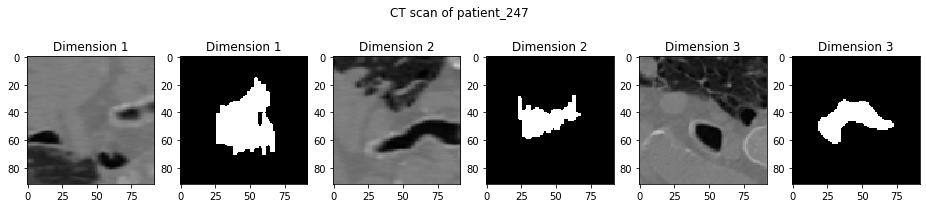

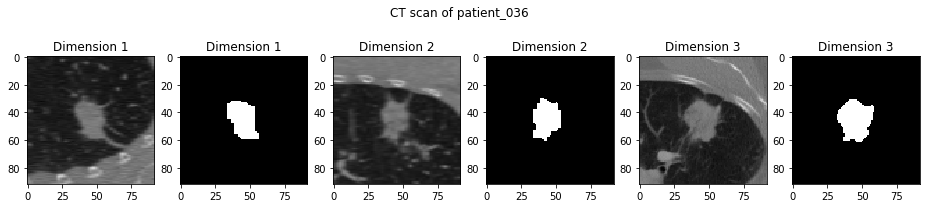

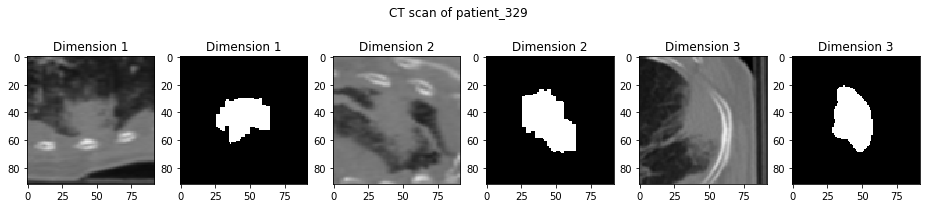

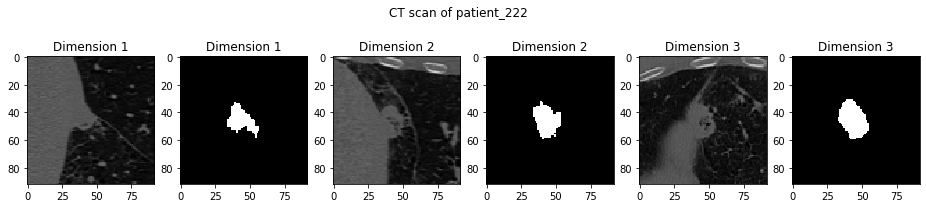

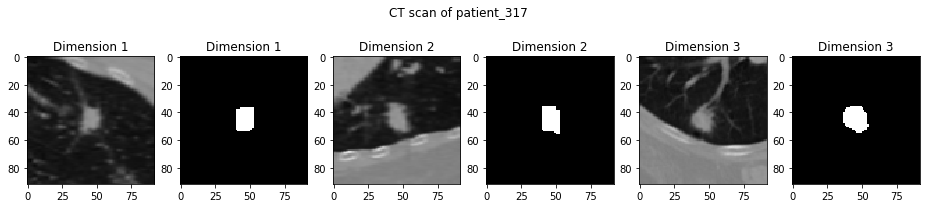

In [102]:
for patient_id in data_train.index[:5]:
    patient_id_str = '00'+str(patient_id)
    patient_id_str = patient_id_str[-3:]
    archive = np.load(os.path.join(train_root,'images/patient_{}.npz'.format(patient_id_str)))
    scan = archive['scan'] # a np.array
    mask = archive['mask'] # a np.array
    
    plt.figure(figsize=(16,8))
    plt.suptitle('CT scan of patient_{}'.format(patient_id_str), y=0.7)
    
    for slice_dim in range(3):
        slice_of_interest = np.zeros((92,92,3))
        soi = get_slice(to_pixel_values(scan), mask, slice_dim)
        for dim in range(3):
            slice_of_interest[:,:,dim] = soi
        slice_of_interest = slice_of_interest.astype(int)
    
        plt.subplot(1,6,2*slice_dim+1)
        plt.imshow(slice_of_interest)
        plt.title('Dimension {}'.format(slice_dim+1))
        
        mask_of_interest = np.zeros((92,92,3))
        moi = get_slice(mask, mask, slice_dim)
        for dim in range(3):
            mask_of_interest[:,:,dim] = moi
        mask_of_interest = mask_of_interest.astype(int)*255
    
        plt.subplot(1,6,2*slice_dim+2)
        plt.imshow(mask_of_interest)
        plt.title('Dimension {}'.format(slice_dim+1))

    plt.show()

In [374]:
img_features_dim = []
for slice_dim in range(3):
    img_features_dim.append(feature_extractor(over_masked_images=False, slice_dim=slice_dim))

300it [01:07,  4.42it/s]
300it [01:03,  4.74it/s]
300it [01:03,  4.72it/s]


In [375]:
new_columns_names = ['Img{}_Feature_{}'.format(slice_dim, feat_idx) for slice_dim in range(3) for feat_idx in range(1,2049)]
new_index_names = img_features_dim[0].index
triple_img_features_df = pd.concat(img_features_dim, axis=1)
triple_img_features_df.columns, triple_img_features_df.index = new_columns_names, new_index_names

In [376]:
#-----------------------------------------------------------------------------------------------------
### Remove irrelevant patients
reduced_img_features_df = triple_img_features_df.copy()
reduced_data_train = data_train.copy()
reduced_data_val = data_val.copy()

no_masks_patients = [327,256,3,391,263]
for patient_id in no_masks_patients:
    reduced_img_features_df = reduced_img_features_df.drop(patient_id,axis='index')
    try:
        reduced_data_train = reduced_data_train.drop(patient_id,axis='index')
    except:
        reduced_data_val = reduced_data_val.drop(patient_id,axis='index')

#-----------------------------------------------------------------------------------------------------
### Apply PCA
from sklearn.decomposition import PCA
transformer = PCA(n_components=50) # keep only 100 features
# using PCA(0.99, whiten=True), we can ask it to preserve 99% of the variance in the projected data
ld_data = transformer.fit_transform(reduced_img_features_df)

columns_names = ['Img_Feature_{}'.format(i) for i in range(1,ld_data.shape[1]+1)]

reduced_img_features_df = pd.DataFrame(ld_data, index=reduced_img_features_df.index, columns=columns_names)

#-----------------------------------------------------------------------------------------------------
### Create relevant splits
# Apply the splitting process to the dataframe containing the features
data_features_train = reduced_img_features_df.loc[reduced_data_train.index]
data_features_val = reduced_img_features_df.loc[reduced_data_val.index]

# Rebuild the split using all available columns
reduced_data_train = data.loc[reduced_data_train.index]
reduced_data_val = data.loc[reduced_data_val.index]

# Concatenate the related dataframes to build the splits
reduced_data_train = pd.concat([reduced_data_train, data_features_train], axis=1)
reduced_data_val = pd.concat([reduced_data_val, data_features_val], axis=1)

**Lifelines :**

In [377]:
features_names = ['SurvivalTime', 'Event', 'SourceDataset', 'Nstage', 
                  'original_shape_Sphericity', 'original_shape_SurfaceVolumeRatio', 
                  'original_shape_Maximum3DDiameter', 'original_glcm_JointEntropy',
                  'original_glcm_Idm','original_glcm_Id'] + list(reduced_img_features_df.columns)

(cph, reduced_data_train, reduced_data_val, _) = predict_lifelines_cox(reduced_data_train, reduced_data_val,
                                                                    features_names)

n=236, number of events=129

                                      coef          exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95    
SourceDataset                      -0.4150             0.6604    0.4438 -0.9349 0.3498     -1.2849      0.4550    
Nstage                              0.3053             1.3571    0.1032  2.9581 0.0031      0.1030      0.5077  **
original_shape_Sphericity           6.1191           454.4660    2.1949  2.7878 0.0053      1.8171     10.4211  **
original_shape_SurfaceVolumeRatio   3.2991            27.0874    1.6300  2.0240 0.0430      0.1043      6.4938   *
original_shape_Maximum3DDiameter    0.0186             1.0188    0.0060  3.0982 0.0019      0.0068      0.0304  **
original_glcm_JointEntropy          0.8901             2.4354    0.3790  2.3483 0.0189      0.1472      1.6330   *
original_glcm_Idm                  29.5940 7120173824674.4883   27.9079  1.0604 0.2890    -25.1045     84.2925    
original_glcm_Id                  -21.5823         

And finally, iterate to select only relevant features :

In [378]:
best_cph, best_result = lifelines_cox_param_selection(cph, features_names, reduced_data_train,
                                                      reduced_data_val, p_value_thresh=0.05)
print('Performance on the validation set (CI) : {:.3f}'.format(best_result))

Performance on the validation set (CI) : 0.700
Performance on the validation set (CI) : 0.700
Performance on the validation set (CI) : 0.708
n=236, number of events=129

                                    coef  exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95     
Nstage                            0.2558     1.2915    0.0808  3.1681 0.0015      0.0976      0.4141   **
original_shape_Sphericity         4.4358    84.4175    1.2371  3.5857 0.0003      2.0112      6.8604  ***
original_shape_Maximum3DDiameter  0.0149     1.0150    0.0035  4.2154 0.0000      0.0080      0.0218  ***
Img_Feature_3                    -0.5843     0.5575    0.2458 -2.3773 0.0174     -1.0661     -0.1026    *
Img_Feature_17                   -0.6958     0.4987    0.2950 -2.3587 0.0183     -1.2739     -0.1176    *
Img_Feature_38                    0.6739     1.9619    0.2960  2.2767 0.0228      0.0938      1.2541    *
Img_Feature_43                   -0.8525     0.4263    0.3366 -2.5328 0.0113     -1.5122

**Scikit-survival :**

In [381]:
features_names = ['SurvivalTime', 'Event', 'SourceDataset', 'Nstage', 
                  'original_shape_Sphericity', 'original_shape_SurfaceVolumeRatio', 
                  'original_shape_Maximum3DDiameter', 'original_glcm_JointEntropy',
                  'original_glcm_Idm','original_glcm_Id'] + list(reduced_img_features_df.columns)

(cph, _, _, _) = predict_sksurv_cox(reduced_data_train, reduced_data_val, features_names, 
                                    alpha=100, normalize=False)

Performance on the training set (CI) : 0.714
Performance on the validation set (CI) : 0.685


Unfortunately we get even worse results... The issue probably come from the PCA to reduce the number of parameters which is much to high in a resnet50...

Then, we should try with a resnet18 which extracts 512 features instead of 2048 and capturing convenient features !

In [382]:
features_names = ['SurvivalTime', 'Event', 'SourceDataset', 'Nstage', 
                  'original_shape_Sphericity', 'original_shape_SurfaceVolumeRatio', 
                  'original_shape_Maximum3DDiameter', 'original_glcm_JointEntropy',
                  'original_glcm_Idm','original_glcm_Id'] + list(reduced_img_features_df.columns)

golden_section_search(nb_blocks_range=[1e-3,1e3], train=reduced_data_train, val=reduced_data_val,
                      features=features_names, tol=1e-6, it_max=100)

optimal value reached for : nb_blocks = 3.81e+02
Performance on the training set (CI) : 0.746
Performance on the validation set (CI) : 0.710


Not using a PCA before sksurv takes too much time but what if we use it to keep 99% of the variance ?

In [383]:
#-----------------------------------------------------------------------------------------------------
### Remove irrelevant patients
reduced_img_features_df = triple_img_features_df.copy()
reduced_data_train = data_train.copy()
reduced_data_val = data_val.copy()

no_masks_patients = [327,256,3,391,263]
for patient_id in no_masks_patients:
    reduced_img_features_df = reduced_img_features_df.drop(patient_id,axis='index')
    try:
        reduced_data_train = reduced_data_train.drop(patient_id,axis='index')
    except:
        reduced_data_val = reduced_data_val.drop(patient_id,axis='index')
        
transformer = PCA(0.99, whiten=True)
ld_data = transformer.fit_transform(reduced_img_features_df)
columns_names = ['Img_Feature_{}'.format(i) for i in range(1,ld_data.shape[1]+1)]

reduced_img_features_df = pd.DataFrame(ld_data, index=reduced_img_features_df.index, columns=columns_names)

#-----------------------------------------------------------------------------------------------------
### Create relevant splits
# Apply the splitting process to the dataframe containing the features
data_features_train = reduced_img_features_df.loc[reduced_data_train.index]
data_features_val = reduced_img_features_df.loc[reduced_data_val.index]

# Rebuild the split using all available columns
reduced_data_train = data.loc[reduced_data_train.index]
reduced_data_val = data.loc[reduced_data_val.index]

# Concatenate the related dataframes to build the splits
reduced_data_train = pd.concat([reduced_data_train, data_features_train], axis=1)
reduced_data_val = pd.concat([reduced_data_val, data_features_val], axis=1)

In [384]:
features_names = ['SurvivalTime', 'Event', 'SourceDataset', 'Nstage', 
                  'original_shape_Sphericity', 'original_shape_SurfaceVolumeRatio', 
                  'original_shape_Maximum3DDiameter', 'original_glcm_JointEntropy',
                  'original_glcm_Idm','original_glcm_Id'] + list(reduced_img_features_df.columns)

(cph, _, _, _) = predict_sksurv_cox(reduced_data_train, reduced_data_val, features_names, 
                                    alpha=1e3, normalize=True)

Performance on the training set (CI) : 0.885
Performance on the validation set (CI) : 0.681


Let's submit this model, to have a look at its performance :

In [388]:
(best_cph, _, _, _) = predict_sksurv_cox(reduced_data_train, reduced_data_val, features_names, 
                                         alpha=1e3, normalize=True)

_, _, data_test = normalize_data(reduced_data_train, reduced_data_val, data_test=test_dataset)

model = nn.Sequential(*list(models.resnet50('imagenet').children())[:-2])
# -2 instead of -1 will take off the last AvgPool2d if I want to play a bit.
model = model.double()

img_features_test = []
for slice_dim in range(3):
    features_img = np.ndarray((len(data_test),2048))

    for idx, patient_id in tqdm.tqdm(enumerate(data_test.index)):
        # Load the image
        patient_id_str = '00'+str(patient_id)
        patient_id_str = patient_id_str[-3:]
        archive = np.load(os.path.join(test_root,'images/patient_{}.npz'.format(patient_id_str)))
        scan = archive['scan'] # a np.array
        mask = archive['mask'] # a np.array

        # Get the slice of interest
        try:
            img = get_slice(scan, mask, slice_dim)
            img = to_pixel_values(img)
        except:
            # Patients 404, 50, 234, 311, 198, 199 have empty masks
            img = np.zeros((92,92))

        # Extract features from it using Resnet50
        img_bgr = np.zeros((1, 3, 92, 92))
        # Concerning the normalization, one can either do the following or simply divide by 255
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        for dim in range(3):
            img_bgr[0,dim,:,:] = (img - mean[dim]) / std[dim]
            
        with torch.no_grad():
            img_bgr = torch.from_numpy(img_bgr)#/255.)
            img_bgr = img_bgr.type('torch.DoubleTensor')
            #torch.utils.data.DataLoader(train_dataset, batch_size=1)
            slice_features = model(img_bgr).numpy()
        slice_features = slice_features.mean(2).mean(2)
        slice_features = slice_features.flatten()
        features_img[idx] = slice_features

    columns_names = ['Img_Feature_{}'.format(i) for i in range(1,2049)]

    img_features_df = pd.DataFrame(features_img, columns=columns_names, index=data_test.index)
    
    img_features_test.append(img_features_df)
    

col_names = ['Img{}_Feature_{}'.format(slice_dim, feat_idx) for slice_dim in range(3) for feat_idx in range(1,2049)]
test_features = pd.DataFrame(np.concatenate(img_features_test, axis=1), columns=col_names, index=data_test.index)

#-----------------------------------------------------------------------------------------------------
### Apply PCA
test_ld_data = transformer.transform(test_features)

columns_names = ['Img_Feature_{}'.format(i) for i in range(1,test_ld_data.shape[1]+1)]

test_features = pd.DataFrame(test_ld_data, index=test_features.index, columns=columns_names)

final_data_test = pd.concat([data_test, test_features], axis=1)

features_names = ['SourceDataset', 'Nstage', 
                  'original_shape_Sphericity', 'original_shape_SurfaceVolumeRatio', 
                  'original_shape_Maximum3DDiameter', 'original_glcm_JointEntropy',
                  'original_glcm_Idm','original_glcm_Id'] + list(columns_names)
final_data_test = final_data_test[features_names]
final_data_test

Performance on the training set (CI) : 0.885
Performance on the validation set (CI) : 0.681



0it [00:00, ?it/s]
1it [00:00,  3.87it/s]
2it [00:00,  3.91it/s]
3it [00:00,  3.92it/s]
4it [00:01,  3.91it/s]
5it [00:01,  3.74it/s]
6it [00:01,  3.85it/s]
7it [00:01,  3.88it/s]
8it [00:02,  3.89it/s]
9it [00:02,  4.01it/s]
10it [00:02,  3.92it/s]
11it [00:02,  3.97it/s]
12it [00:03,  3.92it/s]
13it [00:03,  3.83it/s]
14it [00:03,  3.94it/s]
15it [00:03,  3.98it/s]
16it [00:04,  3.94it/s]
17it [00:04,  4.02it/s]
18it [00:04,  3.91it/s]
19it [00:04,  3.90it/s]
20it [00:05,  4.04it/s]
21it [00:05,  4.06it/s]
22it [00:05,  4.14it/s]
23it [00:05,  4.23it/s]
24it [00:06,  4.05it/s]
25it [00:06,  4.07it/s]
26it [00:06,  4.13it/s]
27it [00:06,  4.17it/s]
28it [00:07,  4.18it/s]
29it [00:07,  4.15it/s]
30it [00:07,  4.17it/s]
31it [00:07,  4.11it/s]
32it [00:07,  4.13it/s]
33it [00:08,  4.18it/s]
34it [00:08,  4.20it/s]
35it [00:08,  4.28it/s]
36it [00:08,  4.23it/s]
37it [00:09,  4.18it/s]
38it [00:09,  4.02it/s]
39it [00:09,  4.07it/s]
40it [00:09,  4.12it/s]
41it [00:10,  4.13it/s]
42it 

50it [00:11,  4.25it/s]
51it [00:12,  4.28it/s]
52it [00:12,  4.30it/s]
53it [00:12,  4.30it/s]
54it [00:12,  4.33it/s]
55it [00:12,  4.35it/s]
56it [00:13,  4.33it/s]
57it [00:13,  4.31it/s]
58it [00:13,  4.26it/s]
59it [00:13,  4.27it/s]
60it [00:14,  4.31it/s]
61it [00:14,  4.36it/s]
62it [00:14,  4.29it/s]
63it [00:14,  4.36it/s]
64it [00:15,  4.27it/s]
65it [00:15,  3.79it/s]
66it [00:15,  3.86it/s]
67it [00:15,  3.96it/s]
68it [00:16,  4.09it/s]
69it [00:16,  4.08it/s]
70it [00:16,  4.06it/s]
71it [00:16,  4.00it/s]
72it [00:17,  4.05it/s]
73it [00:17,  4.15it/s]
74it [00:17,  4.19it/s]
75it [00:17,  4.21it/s]
76it [00:18,  4.27it/s]
77it [00:18,  4.33it/s]
78it [00:18,  4.29it/s]
79it [00:18,  4.25it/s]
80it [00:18,  4.19it/s]
81it [00:19,  4.27it/s]
82it [00:19,  4.31it/s]
83it [00:19,  4.30it/s]
84it [00:19,  4.32it/s]
85it [00:20,  4.32it/s]
86it [00:20,  4.40it/s]
87it [00:20,  4.40it/s]
88it [00:20,  4.40it/s]
89it [00:21,  4.25it/s]
90it [00:21,  4.29it/s]
91it [00:21,  4.

In [391]:
test_predictions = np.exp(best_cph.predict(final_data_test), dtype=float)
orders = np.argsort(test_predictions)
for idx, ordr in enumerate(orders):
    test_predictions[ordr] = float(127-idx)

random_events = np.array([float('inf') for _ in test_predictions], dtype=np.float64)
test_output = pd.DataFrame(np.concatenate([test_predictions.reshape(-1,1),random_events.reshape(-1,1)],axis=1),
                           columns=['SurvivalTime', 'Event'], index=final_data_test.index)

test_output.to_csv('my_25D_submission.csv')

---

### II - A - 4 ) Train our own small 3D CNN on a regression task and eventually use it to extract features

Now, we would like to make full use of the 3D property of our data and not only what is called 2,5D. Why do we create our own model ? Well, first of all to the best of my knowledge there isn't any pretrained 3D model available in the litterature, and moreover, a model pretrained on imagenet as before might not be very good to study medical images. For these reasons, we will build our own 3D model using dilated kernels (their efficiency in 3D has been proven in the litterature or at least they are widely used).

Usually Deep Learning is  used for classification. Thus we could train a network to predict the histology of our cohort and then use the network to extract features. But is this approach really a good one ? Indeed, a representation of the images learned by a network trying to predict which tumour it is might not be a good representation to predict survival (cf the survival curves plotted before)...

> A better approach could be instead to remove the final softmax or sigmoid and choose to have only one final neuron. This way our network would be able to perform regression. We then train this network to predict patients' survival : such a network is more likely to get better representations of the tumours for our task. If we do have such a network and that it is trained, then we would have two options : either use the predictions to get a CI score (but in this case the network don't get the subtle issue of patients leaving the study) or use it to extract relevant features for survival prediction that could be passed into a cox model as we did before.

In [116]:
import torch
import torch.nn as nn
import torch.nn.functional as F

**Build the network :**

In [117]:
class Regressor(nn.Module):
    
    def __init__(self):
        super(Regressor,self).__init__()
        self.conv1 = nn.Conv3d(in_channels=1, out_channels=18, kernel_size=3, dilation=2, stride=2)
        # This downscales pretty well images and thus reduces the computation time
        self.pool = nn.MaxPool3d(2)
        self.conv2 = nn.Conv3d(in_channels=18, out_channels=32, kernel_size=3, dilation=2, stride=2)
        self.fc1 = nn.Linear(32 * 9 * 9 * 9, 512) # 32*9*9*9 = 23328 -> downscaling to 512 seems legit
        self.fc2 = nn.Linear(512, 32)
        self.fc3 = nn.Linear(32,1)
        
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x)) #self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 9 * 9 * 9)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = Regressor()
print(model) # Print the layers containing trainable parameters only.

Regressor(
  (conv1): Conv3d(1, 18, kernel_size=(3, 3, 3), stride=(2, 2, 2), dilation=(2, 2, 2))
  (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv3d(18, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), dilation=(2, 2, 2))
  (fc1): Linear(in_features=23328, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)


> Such a model will be able to be trained on my laptop (since I don't currently have gpus). Another possibility would have been to use AWS or colab, but anyway, we don't aim at revolutionizing science here and probably don't have enough images to train a bigger network.

What could be nice is to implement data augmentation for 3D volumes but does it work that easily ? Moreover, it is important that augmented images are still possible images we could come across (stay in the same distribution) ! In our case, we can see the ribs sometimes and the patient seem to be always in the same position with its organs located at certain places. Augmenting the data with rotations and symmetry might not make that much sense... If needed in the future (if I have time and that I have changed my mind), here is the code in 2D to do it :

**If required, add Data Augmentation with the code below :**

```python

import cv2
import numpy as np


class Preprocessing(): 
    def __init__(self, config): 
        self.transforms = []
        if hasattr(config, 'resize'):
            self.transforms.append(Resize(config.resize.scale, keep_ratio=config.resize.keep_ratio))
        if hasattr(config, 'random_rotation'): 
            self.transforms.append(Random_rotation(config.random_rotation.angle))
        if hasattr(config, 'random_crop'): 
            self.transforms.append(Random_crop(config.random_crop.proportion))
        if hasattr(config, 'random_flip'): 
            self.transforms.append(Random_flip(config.random_flip.probability))
            
    def __call__(self,img): 
        for t in self.transforms: 
            img = t(img)
        return img
    
    
class Resize():
    
    def __init__(self, scale, keep_ratio=True):
            self.scale = scale
            self.keep_ratio = keep_ratio
            
    def __call__(self, img): 
        if self.keep_ratio:
            h, w, _ = img.shape
            ratio = max(self.scale[0] / h, self.scale[1] / w)
            img = cv2.resize(img, dsize=None, fx=ratio, fy=ratio)
            img = cv2.copyMakeBorder(img, max(0, self.scale[0] - img.shape[0]) // 2, 
                                         max(0, self.scale[0] - img.shape[0]) // 2 + 1,
                                         max(0, self.scale[1] - img.shape[1]) // 2,
                                         max(0, self.scale[1] - img.shape[1]) // 2 + 1,
                                         cv2.BORDER_CONSTANT, 0)
            h, w, _ = img.shape
            img = img[h // 2 - self.scale[0] // 2 : h // 2 + self.scale[0] // 2 ,
              w // 2 - self.scale[1] // 2 : w // 2 + self.scale[1] // 2 ,:]
        else: 
            raise NotImplementedError('keep ratio == False is  not implemented')
        return img
    
    
class Random_rotation():
    def __init__(self, angle):
        self.angle = angle
    def __call__(self, img):
        rows,cols,_ = img.shape
        angle = (2 * np.random.random() - 1) * self.angle 
        M = cv2.getRotationMatrix2D(((cols-1)/2.0,(rows-1)/2.0),angle,1)
        img = cv2.warpAffine(img,M,(cols,rows))
        return img
        
class Random_crop():
    def __init__(self, proportion):
        self.proportion = proportion
    def __call__(self, img): 
        proportion = 1 - (1- self.proportion) * np.random.random()
        h, w, _ = img.shape 
        x_min, y_min = np.random.randint(0, max(1,h - proportion * h)) , np.random.randint(0, max(1,w - proportion * w)) 
        img = img[x_min : x_min + int(proportion * h),
                  y_min : y_min + int( proportion * w), :]
        return img
    
class Random_flip():
    def __init__(self, probability):
        self.probability = probability
    def __call__(self, img): 
        if np.random.random() < self.probability :
            img = cv2.flip(img, flipCode=1)
        return img
    
```

**We need to create the dataset class properly in order to be called by torch's `DataLoader` function.**

In [118]:
from torchvision import transforms

class SurvivalDataset(object):
    '''
    The SurvivalDataset instance inherit from the standard torch.utils.data.Dataset, it 
    corresponds to the survival dataset structure
    
    Parameters
    ----------
    image_dir : str
        path to the data main folder
        
    info_file : pandas DataFrame 
        file containing the images info
        
    split_name : str in ['train', 'val', 'test']
        which type of split it is
    
    augmentation : dict
        which augmentation to apply to data
    
    Attributes
    ----------
    image_dir : str 
        path to the data main folder which contains the
        images in training_data/images or test_data/images
    samples : pandas.Dataframe
        the Dataframe containing the information about the different images of the dataset
    '''
    def __init__(self, image_dir, info_file, split_name, augmentation=None, normalization=False):
        self.image_dir = image_dir
        # load all image files, sorting them to
        # ensure that they are aligned 
        
        self.samples = info_file
        
        self.samples.rename(columns={'SurvivalTime':'label'}, inplace=True)
            
        if normalization:
            self.normalization = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                      std=[0.229, 0.224, 0.225])
        else:
            self.normalization = None
        
        if split_name == 'train' and augmentation!=None:
            self.augmentation = Preprocessing(augmentation)
        else : 
            self.augmentation = None   
        
        
    def __getitem__(self, idx):
        # load images and masks
        infos = self.samples.iloc[idx]
        patient_id = infos.name
        patient_id_str = '00'+str(patient_id)
        patient_id_str = patient_id_str[-3:]
        path = 'patient_{}.npz'.format(patient_id_str)
        img_path = os.path.join(self.image_dir, path)
        scan = np.load(img_path)['scan']
        img = to_pixel_values(scan)
        
        infos = infos.to_dict()
        
        img = img.copy().astype(np.float32, copy=True)
        
        if self.normalization is not None: 
            img = self.normalization(torch.from_numpy(img)).numpy()
        else:
            img = img / 255.
        
        if self.augmentation is not None: 
            img = self.augmentation(img)

        img = img.reshape(1,92,92,92)
        return img, infos
    
    def __len__(self):
        return self.samples.shape[0]

**Now, we have to train this NN regressor :**

In [138]:
## import torch.optim as optim

train_dataset = SurvivalDataset(image_dir='training_data/images', info_file=data_train, split_name='train')
train_data_loader = torch.utils.data.DataLoader(train_dataset,batch_size=24, num_workers=0, drop_last=True)
validation_dataset = SurvivalDataset(image_dir='training_data/images', info_file=data_val, split_name='val')
val_data_loader = torch.utils.data.DataLoader(validation_dataset,batch_size=24, num_workers=0, drop_last=True)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = Regressor()
model.to(device)

loss_function = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
num_epochs = 100

train_errors = []
val_errors = []
model.train()
for epoch in range(num_epochs): # loop over the dataset multiple times
    avg_loss = 0.0
    for batch_idx, (inputs, labels) in enumerate(train_data_loader,0): 
        # get the inputs
        inputs, labels = inputs.to(device), (labels['label']).to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = model(inputs)
        labels = labels.type(torch.float32)/1000. # In order to prevent NaN issues
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
            
        if avg_loss == 0 : 
            avg_loss = loss.item()
        avg_loss = 0.9 * avg_loss + 0.1 * loss.item()
        if (batch_idx+1) % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tavg Loss: {:.4f}\t Loss: {:.4f}'.format(
                epoch, batch_idx * len(inputs), len(train_data_loader.dataset),
                100. * batch_idx / len(train_data_loader), avg_loss, loss.item()))
    
    train_errors.append(avg_loss)
    
    # Evaluate the model on the validation set
    model.eval()
    with torch.no_grad():
        validation_loss = 0
        for batch_idx, (inputs, labels) in enumerate(val_data_loader):
            inputs, labels = inputs.to(device), (labels['label']).to(device)
            output = model(inputs)
            labels = labels.type(torch.float32)/1000. # In order to prevent NaN issues
            validation_loss += loss_function(output, labels).item()  # sum up batch loss

        val_loss = validation_loss/len(val_data_loader)
        print('epoch : {}, val_loss : {:.4f}'.format(epoch+1, val_loss))
    
    val_errors.append(val_loss)
    
#torch.save(model.state_dict(), './my_reg_CNN_3D.pth')

my_model = model
            
print('Finished Training')

Train Epoch: 0 [216/240 (90%)]	avg Loss: 0.9687	 Loss: 0.6162
epoch : 1, val_loss : 0.6792
Train Epoch: 1 [216/240 (90%)]	avg Loss: 0.6037	 Loss: 0.6770
epoch : 2, val_loss : 0.6308
Train Epoch: 2 [216/240 (90%)]	avg Loss: 0.5374	 Loss: 0.5891
epoch : 3, val_loss : 0.6511
Train Epoch: 3 [216/240 (90%)]	avg Loss: 0.5567	 Loss: 0.6444
epoch : 4, val_loss : 0.6246
Train Epoch: 4 [216/240 (90%)]	avg Loss: 0.5214	 Loss: 0.5924
epoch : 5, val_loss : 0.6287
Train Epoch: 5 [216/240 (90%)]	avg Loss: 0.5336	 Loss: 0.6091
epoch : 6, val_loss : 0.6180
Train Epoch: 6 [216/240 (90%)]	avg Loss: 0.5220	 Loss: 0.6000
epoch : 7, val_loss : 0.6188
Train Epoch: 7 [216/240 (90%)]	avg Loss: 0.5235	 Loss: 0.5992
epoch : 8, val_loss : 0.6166
Train Epoch: 8 [216/240 (90%)]	avg Loss: 0.5216	 Loss: 0.6002
epoch : 9, val_loss : 0.6151
Train Epoch: 9 [216/240 (90%)]	avg Loss: 0.5196	 Loss: 0.5970
epoch : 10, val_loss : 0.6147
Train Epoch: 10 [216/240 (90%)]	avg Loss: 0.5194	 Loss: 0.5978
epoch : 11, val_loss : 0.6

epoch : 89, val_loss : 0.6101
Train Epoch: 89 [216/240 (90%)]	avg Loss: 0.5098	 Loss: 0.5942
epoch : 90, val_loss : 0.6101
Train Epoch: 90 [216/240 (90%)]	avg Loss: 0.5097	 Loss: 0.5942
epoch : 91, val_loss : 0.6101
Train Epoch: 91 [216/240 (90%)]	avg Loss: 0.5097	 Loss: 0.5942
epoch : 92, val_loss : 0.6101
Train Epoch: 92 [216/240 (90%)]	avg Loss: 0.5097	 Loss: 0.5942
epoch : 93, val_loss : 0.6101
Train Epoch: 93 [216/240 (90%)]	avg Loss: 0.5096	 Loss: 0.5942
epoch : 94, val_loss : 0.6101
Train Epoch: 94 [216/240 (90%)]	avg Loss: 0.5096	 Loss: 0.5942
epoch : 95, val_loss : 0.6102
Train Epoch: 95 [216/240 (90%)]	avg Loss: 0.5096	 Loss: 0.5942
epoch : 96, val_loss : 0.6102
Train Epoch: 96 [216/240 (90%)]	avg Loss: 0.5095	 Loss: 0.5942
epoch : 97, val_loss : 0.6102
Train Epoch: 97 [216/240 (90%)]	avg Loss: 0.5095	 Loss: 0.5942
epoch : 98, val_loss : 0.6103
Train Epoch: 98 [216/240 (90%)]	avg Loss: 0.5094	 Loss: 0.5942
epoch : 99, val_loss : 0.6103
Train Epoch: 99 [216/240 (90%)]	avg Loss

Even if the model doesn't seem to get better after 20 epochs, it is still learning by very low steps and in fact the survival estimations appear to be much better !!

Let's visualize training :

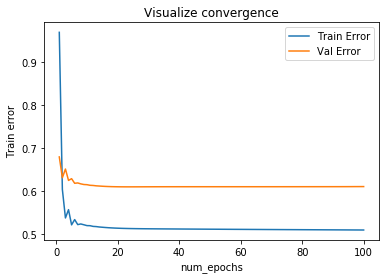

In [139]:
plt.plot(range(1, len(train_errors)+1), train_errors, label='Train Error')
plt.plot(range(1, len(train_errors)+1), val_errors, label='Val Error')
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title('Visualize convergence')
plt.legend()

If needed, I can now reload the model using :

```python
my_model = Regressor()
my_model.load_state_dict(torch.load('./my_reg_CNN_3D.pth'))
```

Now let's test it on the validation set :

**1 - Computing directly the survival in days**

In [140]:
# Evaluate the model on the validation set
predictions = []
my_model.eval()
with torch.no_grad():
    for patient_id in tqdm.tqdm(data_val.index):
        patient_id_str = '00'+str(patient_id)
        patient_id_str = patient_id_str[-3:]
        path = 'patient_{}.npz'.format(patient_id_str)
        img_path = os.path.join('training_data/images', path)
        scan = np.load(img_path)['scan']
        img = to_pixel_values(scan)
        
        img = img.copy().astype(np.float32, copy=True)
        img = img.reshape(1,1,92,92,92)
        img = torch.from_numpy(img)
        if SurvivalDataset.normalization is not None:
            img = SurvivalDataset.normalization(img)
        else:    
            img /= 255
        img = img.to(device)
        output = my_model(img)*1000. # Because of our trick to prevent NaN issues in the training.
        predictions.append(output.numpy())
        
predictions = pd.DataFrame(np.array(predictions).flatten(), columns=['SurvivalTime'], index=data_val.index)
predictions

100%|██████████| 60/60 [00:04<00:00, 14.43it/s]


,SurvivalTime
PatientID,
283,810.821533
176,846.957764
11,837.131592
286,896.485352
171,825.958557
51,894.867920
386,828.492615
290,882.279663
163,890.832825


In [141]:
pred = pd.concat([predictions, data_val['Event']], axis=1)
    
data_val.rename(columns={'label':'SurvivalTime'}, inplace=True)
result = cindex(data_val[['SurvivalTime', 'Event']], pred)
print('Performance on the validation set (CI) : {:.3f}'.format(result))

Performance on the validation set (CI) : 0.610


**2 - Use the 3D_CNN to extract relevant features**

In [142]:
# Evaluate the model on the validation set
model_list = list(my_model.children())[:-1]
### We might have to reproduce the forward function :
#p1_model_list = model_list[:3] + [model_list[1]]
#p2_model_list = model_list[3:]
#trunc_model_p1 = nn.Sequential(*p1_model_list)
#trunc_model_p2 = nn.Sequential(*p2_model_list)

### Or if we don't : (but still, we have the issue of the .view function in the forward)
p1_model_list = model_list[:3]
p2_model_list = model_list[3:]
trunc_model_p1 = nn.Sequential(*p1_model_list)
trunc_model_p2 = nn.Sequential(*p2_model_list)

features_img = np.ndarray((len(data),32))
#trunc_model.eval()
with torch.no_grad():
    for idx, patient_id in tqdm.tqdm(enumerate(data.index)):
        patient_id_str = '00'+str(patient_id)
        patient_id_str = patient_id_str[-3:]
        path = 'patient_{}.npz'.format(patient_id_str)
        img_path = os.path.join('training_data/images', path)
        scan = np.load(img_path)['scan']
        img = to_pixel_values(scan)
        
        img = img.copy().astype(np.float32, copy=True)
        img = img.reshape(1,1,92,92,92)
        img = torch.from_numpy(img)
        if SurvivalDataset.normalization is not None:
            img = SurvivalDataset.normalization(img)
        else:    
            img /= 255
        img = img.to(device)
        interm = trunc_model_p1(img)
        interm = interm.view(-1, 32 * 9 * 9 * 9)
        output = trunc_model_p2(interm)
        features_img[idx] = output.numpy()
        
features_3D = pd.DataFrame(features_img, columns=['Feature_3D_{}'.format(k) for k in range(1,33)], 
                           index=data.index)
features_3D

300it [00:18, 15.94it/s]


,Feature_3D_1,Feature_3D_2,Feature_3D_3,Feature_3D_4,Feature_3D_5,Feature_3D_6,Feature_3D_7,Feature_3D_8,Feature_3D_9,Feature_3D_10,...,Feature_3D_23,Feature_3D_24,Feature_3D_25,Feature_3D_26,Feature_3D_27,Feature_3D_28,Feature_3D_29,Feature_3D_30,Feature_3D_31,Feature_3D_32
PatientID,,,,,,,,,,,,,,,,,,,,,
202,0.625151,-0.090395,-0.161835,0.565254,-0.222793,0.204048,0.146021,0.531355,0.639556,-0.087416,...,-0.199012,0.427736,-0.060927,0.512132,-0.081308,-0.005312,-0.086385,-0.026994,-0.123641,-0.200613
371,0.682592,-0.123660,-0.161002,0.551103,-0.206071,0.271270,0.134910,0.564480,0.711074,-0.086195,...,-0.229341,0.427682,-0.005860,0.594280,-0.046497,0.005723,-0.121683,0.031842,-0.121710,-0.184185
246,0.647070,-0.083716,-0.178405,0.540910,-0.196307,0.238533,0.137263,0.534926,0.628699,-0.077860,...,-0.161170,0.423260,-0.029813,0.515616,-0.074720,-0.008335,-0.138219,0.009216,-0.115314,-0.176833
240,0.632976,-0.092869,-0.172534,0.558687,-0.200701,0.260682,0.139304,0.556508,0.643742,-0.045530,...,-0.169682,0.399824,-0.028135,0.553784,-0.058692,0.001009,-0.127078,0.006854,-0.106585,-0.187663
284,0.649214,-0.044610,-0.204837,0.543922,-0.223909,0.237576,0.099433,0.525318,0.636191,-0.114367,...,-0.189994,0.474854,-0.005600,0.536294,-0.100395,-0.021049,-0.116049,0.066546,-0.182782,-0.231606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,0.583368,-0.044332,-0.198922,0.503384,-0.217865,0.211746,0.083322,0.477884,0.570213,-0.046960,...,-0.140506,0.382715,-0.047023,0.482678,-0.048599,0.034848,-0.119351,-0.010181,-0.103508,-0.165707
298,0.670916,-0.103759,-0.167821,0.498693,-0.201643,0.271294,0.098518,0.568508,0.656409,-0.081741,...,-0.191999,0.435265,-0.022343,0.569563,-0.098747,0.006913,-0.106298,0.053481,-0.152570,-0.227624
129,0.694835,-0.062107,-0.218204,0.505443,-0.225131,0.263670,0.111540,0.586770,0.709069,-0.138599,...,-0.199658,0.479206,-0.032034,0.561951,-0.087472,-0.021989,-0.110592,0.050645,-0.181883,-0.220743


> Unfortunately it seems that every features values are very similar for every patient... 

In [144]:
#-----------------------------------------------------------------------------------------------------
### Remove irrelevant patients
reduced_img_features_df = features_3D.copy()
reduced_data_train = data_train.copy()
reduced_data_val = data_val.copy()

no_masks_patients = [327,256,3,391,263]
for patient_id in no_masks_patients:
    reduced_img_features_df = reduced_img_features_df.drop(patient_id,axis='index')
    try:
        reduced_data_train = reduced_data_train.drop(patient_id,axis='index')
    except:
        reduced_data_val = reduced_data_val.drop(patient_id,axis='index')

#-----------------------------------------------------------------------------------------------------
### Apply PCA
from sklearn.decomposition import PCA
transformer = PCA(n_components=32) # Don't apply PCA since 32 is already very low !
# using PCA(0.99, whiten=True), we can ask it to preserve 99% of the variance in the projected data
ld_data = transformer.fit_transform(reduced_img_features_df)

columns_names = ['Img_Feature_{}'.format(i) for i in range(1,ld_data.shape[1]+1)]

reduced_img_features_df = pd.DataFrame(ld_data, index=reduced_img_features_df.index, columns=columns_names)

#-----------------------------------------------------------------------------------------------------
### Create relevant splits
# Apply the splitting process to the dataframe containing the features
data_features_train = reduced_img_features_df.loc[reduced_data_train.index]
data_features_val = reduced_img_features_df.loc[reduced_data_val.index]

# Rebuild the split using all available columns
reduced_data_train = data.loc[reduced_data_train.index]
reduced_data_val = data.loc[reduced_data_val.index]

# Concatenate the related dataframes to build the splits
reduced_data_train = pd.concat([reduced_data_train, data_features_train], axis=1)
reduced_data_val = pd.concat([reduced_data_val, data_features_val], axis=1)

**Lifelines :**

In [145]:
features_names = ['SurvivalTime', 'Event', 'SourceDataset', 'Nstage', 
                  'original_shape_Sphericity', 'original_shape_SurfaceVolumeRatio', 
                  'original_shape_Maximum3DDiameter', 'original_glcm_JointEntropy',
                  'original_glcm_Idm','original_glcm_Id'] + list(reduced_img_features_df.columns)

(cph, reduced_data_train, reduced_data_val, _) = predict_lifelines_cox(reduced_data_train, reduced_data_val,
                                                                    features_names)

/anaconda3/lib/python3.6/site-packages/lifelines/utils/__init__.py:1059: ConvergenceWarning: "Column(s) ['Img_Feature_26', 'Img_Feature_27', 'Img_Feature_28', 'Img_Feature_29', 'Img_Feature_30', 'Img_Feature_31', 'Img_Feature_32'] have very low variance. This may harm convergence. Try dropping this redundant column before fitting if convergence fails."
  warnings.warn(warning_text, ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/lifelines/utils/__init__.py:1071: ConvergenceWarning: "Column(s) ['Img_Feature_28', 'Img_Feature_29', 'Img_Feature_30', 'Img_Feature_31', 'Img_Feature_32'] have very low variance when conditioned on death event or not. This may harm convergence. This could be a form of 'complete separation'. See https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faqwhat-is-complete-or-quasi-complete-separation-in-logisticprobit-regression-and-how-do-we-deal-with-them/ "
  warnings.warn(warning_text, ConvergenceWarning)


n=236, number of events=129

                                      coef       exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95     
SourceDataset                      -0.6614          0.5161    0.3989 -1.6580 0.0973     -1.4432      0.1204    .
Nstage                              0.3383          1.4026    0.0919  3.6822 0.0002      0.1582      0.5184  ***
original_shape_Sphericity           3.4561         31.6945    1.8545  1.8636 0.0624     -0.1787      7.0910    .
original_shape_SurfaceVolumeRatio   4.5808         97.5913    1.4850  3.0847 0.0020      1.6703      7.4913   **
original_shape_Maximum3DDiameter    0.0163          1.0165    0.0059  2.7923 0.0052      0.0049      0.0278   **
original_glcm_JointEntropy          0.8674          2.3807    0.3456  2.5095 0.0121      0.1900      1.5448    *
original_glcm_Idm                   4.6762        107.3580   25.0672  0.1865 0.8520    -44.4546     53.8070     
original_glcm_Id                    4.3750         79.4394   29.601

And finally, iterate to select only relevant features :

In [146]:
best_cph, best_result = lifelines_cox_param_selection(cph, features_names, reduced_data_train, 
                                                      reduced_data_val, p_value_thresh=0.05)
print('Performance on the validation set (CI) : {:.3f}'.format(best_result))

Performance on the validation set (CI) : 0.603
Performance on the validation set (CI) : 0.514
n=236, number of events=129

                                      coef      exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95     
Nstage                              0.2965         1.3451    0.0809  3.6673 0.0002      0.1380      0.4550  ***
original_shape_SurfaceVolumeRatio   1.1234         3.0754    0.9236  1.2164 0.2238     -0.6868      2.9337     
original_shape_Maximum3DDiameter    0.0060         1.0060    0.0036  1.6770 0.0935     -0.0010      0.0129    .
original_glcm_JointEntropy         -0.0944         0.9099    0.0717 -1.3165 0.1880     -0.2350      0.0462     
Img_Feature_2                       3.0903        21.9834    1.6932  1.8251 0.0680     -0.2283      6.4089    .
Img_Feature_5                       4.8539       128.2388    3.2865  1.4769 0.1397     -1.5876     11.2954     
Img_Feature_11                     12.7956    360643.0296    5.1051  2.5064 0.0122      2.789

**Scikit-survival :**

In [147]:
features_names = ['SurvivalTime', 'Event', 'SourceDataset', 'Nstage', 
                  'original_shape_Sphericity', 'original_shape_SurfaceVolumeRatio', 
                  'original_shape_Maximum3DDiameter', 'original_glcm_JointEntropy',
                  'original_glcm_Idm','original_glcm_Id'] + list(reduced_img_features_df.columns)

(cph, _, _, _) = predict_sksurv_cox(reduced_data_train, reduced_data_val, features_names, 
                                    alpha=100, normalize=False)

Performance on the training set (CI) : 0.688
Performance on the validation set (CI) : 0.683


> Hmm, it doesn't yield amazing results unfortunately...

In [148]:
features_names = ['SurvivalTime', 'Event', 'SourceDataset', 'Nstage', 
                  'original_shape_Sphericity', 'original_shape_SurfaceVolumeRatio', 
                  'original_shape_Maximum3DDiameter', 'original_glcm_JointEntropy',
                  'original_glcm_Idm','original_glcm_Id'] + list(reduced_img_features_df.columns)

golden_section_search(nb_blocks_range=[1e-3,1e3], train=reduced_data_train, val=reduced_data_val,
                      features=features_names, tol=1e-6, it_max=100)

optimal value reached for : nb_blocks = 6.15e+02
Performance on the training set (CI) : 0.713
Performance on the validation set (CI) : 0.683


Still not improving drastically the results...

---
---
---

> A major issue with this is that the model would actually not get the fact that people escape the study ! Thus, it may face a label that is actually inconsistent since it is not the true survival in days but juste the survival in days until the patient has escaped the study... A first solution to this could be to only consider patients that stayed in the study until their death.

---
---
---

**3 - Train the model considering only patients with Event=1**

In [149]:
import torch.optim as optim

train_dataset = SurvivalDataset(image_dir='training_data/images', info_file=data_train[data_train['Event']==1],
                                split_name='train')
train_data_loader = torch.utils.data.DataLoader(train_dataset,batch_size=26, num_workers=0, drop_last=True)
validation_dataset = SurvivalDataset(image_dir='training_data/images', info_file=data_val[data_val['Event']==1],
                                     split_name='val')
val_data_loader = torch.utils.data.DataLoader(validation_dataset,batch_size=26, num_workers=0, drop_last=True)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = Regressor()
model.to(device)

loss_function = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
num_epochs = 50

train_errors = []
val_errors = []
model.train()
for epoch in range(num_epochs): # loop over the dataset multiple times
    avg_loss = 0.0
    for batch_idx, (inputs, labels) in enumerate(train_data_loader,0): 
        # get the inputs
        inputs, labels = inputs.to(device), (labels['label']).to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = model(inputs)
        labels = labels.type(torch.float32)/1000. # In order to prevent NaN issues
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
            
        if avg_loss == 0 : 
            avg_loss = loss.item()
        avg_loss = 0.9 * avg_loss + 0.1 * loss.item()
        if (batch_idx+1) % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tavg Loss: {:.6e}\t Loss: {:.6e}'.format(
                epoch, batch_idx * len(inputs), len(train_data_loader.dataset),
                100. * batch_idx / len(train_data_loader), avg_loss, loss.item()))
    
    train_errors.append(avg_loss)
    
    # Evaluate the model on the validation set
    model.eval()
    with torch.no_grad():
        validation_loss = 0
        for batch_idx, (inputs, labels) in enumerate(val_data_loader):
            inputs, labels = inputs.to(device), (labels['label']).to(device)
            output = model(inputs)
            labels = labels.type(torch.float32)/1000. # In order to prevent NaN issues
            validation_loss += loss_function(output, labels).item()  # sum up batch loss

        val_loss = validation_loss/len(val_data_loader)
        print('epoch : {}, val_loss : {}'.format(epoch+1, val_loss))
    
    val_errors.append(val_loss)
    
torch.save(model.state_dict(), './my_reg_CNN_3D_event1.pth')

my_model = model
            
print('Finished Training')

epoch : 1, val_loss : 0.6682555079460144
epoch : 2, val_loss : 0.48737987875938416
epoch : 3, val_loss : 0.3054254353046417
epoch : 4, val_loss : 0.31138086318969727
epoch : 5, val_loss : 0.2934145927429199
epoch : 6, val_loss : 0.28445005416870117
epoch : 7, val_loss : 0.29698070883750916
epoch : 8, val_loss : 0.2886861562728882
epoch : 9, val_loss : 0.2794085741043091
epoch : 10, val_loss : 0.2785775065422058
epoch : 11, val_loss : 0.27816978096961975
epoch : 12, val_loss : 0.2794470191001892
epoch : 13, val_loss : 0.2807093560695648
epoch : 14, val_loss : 0.279794305562973
epoch : 15, val_loss : 0.2784139811992645
epoch : 16, val_loss : 0.27780914306640625
epoch : 17, val_loss : 0.27785149216651917
epoch : 18, val_loss : 0.27819159626960754
epoch : 19, val_loss : 0.2783445119857788
epoch : 20, val_loss : 0.27812460064888
epoch : 21, val_loss : 0.27777913212776184
epoch : 22, val_loss : 0.27755990624427795
epoch : 23, val_loss : 0.27751031517982483
epoch : 24, val_loss : 0.2775336503

> It seems to train much better !!

Let's have a look at its direct predictions :

In [150]:
# Evaluate the model on the validation set
predictions = []
my_model.eval()
with torch.no_grad():
    for patient_id in tqdm.tqdm(data_val[data_val['Event']==1].index):
        patient_id_str = '00'+str(patient_id)
        patient_id_str = patient_id_str[-3:]
        path = 'patient_{}.npz'.format(patient_id_str)
        img_path = os.path.join('training_data/images', path)
        scan = np.load(img_path)['scan']
        img = to_pixel_values(scan)
        
        img = img.copy().astype(np.float32, copy=True)
        img = img.reshape(1,1,92,92,92)
        img = torch.from_numpy(img)
        if SurvivalDataset.normalization is not None:
            img = SurvivalDataset.normalization(img)
        else:    
            img /= 255
        img = img.to(device)
        output = my_model(img)*1000. # Because of our trick to prevent NaN issues in the training.
        predictions.append(output.numpy())
        
predictions = pd.DataFrame(np.array(predictions).flatten(), columns=['SurvivalTime'], 
                           index=data_val[data_val['Event']==1].index)
predictions

100%|██████████| 32/32 [00:02<00:00, 14.18it/s]


,SurvivalTime
PatientID,
283,529.063904
176,501.660828
171,491.962738
290,455.937195
295,493.661285
384,495.597900
378,486.344574
258,503.132812
221,527.759399


In [151]:
pred = pd.concat([predictions, data_val[data_val['Event']==1]['Event']], axis=1)
    
data_val.rename(columns={'label':'SurvivalTime'}, inplace=True)
result = cindex(data_val[data_val['Event']==1][['SurvivalTime', 'Event']], pred)
print('Performance on the validation set (CI) : {:.3f}'.format(result))

Performance on the validation set (CI) : 0.309


> The results are a little bit better, but given that we have only half of the data, probably that the approach is a better one and we should work on it if we could.

Then we could try to extract features :

In [152]:
# Evaluate the model on the validation set
model_list = list(my_model.children())[:-1]
### We might have to reproduce the forward function :
#p1_model_list = model_list[:3] + [model_list[1]]
#p2_model_list = model_list[3:]
#trunc_model_p1 = nn.Sequential(*p1_model_list)
#trunc_model_p2 = nn.Sequential(*p2_model_list)

### Or if we don't : (but still, we have the issue of the .view function in the forward)
p1_model_list = model_list[:3]
p2_model_list = model_list[3:]
trunc_model_p1 = nn.Sequential(*p1_model_list)
trunc_model_p2 = nn.Sequential(*p2_model_list)

features_img = np.ndarray((len(data[data['Event']==1]),32))
#trunc_model.eval()
with torch.no_grad():
    for idx, patient_id in tqdm.tqdm(enumerate(data[data['Event']==1].index)):
        patient_id_str = '00'+str(patient_id)
        patient_id_str = patient_id_str[-3:]
        path = 'patient_{}.npz'.format(patient_id_str)
        img_path = os.path.join('training_data/images', path)
        scan = np.load(img_path)['scan']
        img = to_pixel_values(scan)
        
        img = img.copy().astype(np.float32, copy=True)
        img = img.reshape(1,1,92,92,92)
        img = torch.from_numpy(img)
        if SurvivalDataset.normalization is not None:
            img = SurvivalDataset.normalization(img)
        else:    
            img /= 255
        img = img.to(device)
        interm = trunc_model_p1(img)
        interm = interm.view(-1, 32 * 9 * 9 * 9)
        output = trunc_model_p2(interm)
        features_img[idx] = output.numpy()
        
features_3D = pd.DataFrame(features_img, columns=['Feature_3D_{}'.format(k) for k in range(1,33)], 
                           index=data[data['Event']==1].index)
features_3D

162it [00:10, 15.76it/s]


,Feature_3D_1,Feature_3D_2,Feature_3D_3,Feature_3D_4,Feature_3D_5,Feature_3D_6,Feature_3D_7,Feature_3D_8,Feature_3D_9,Feature_3D_10,...,Feature_3D_23,Feature_3D_24,Feature_3D_25,Feature_3D_26,Feature_3D_27,Feature_3D_28,Feature_3D_29,Feature_3D_30,Feature_3D_31,Feature_3D_32
PatientID,,,,,,,,,,,,,,,,,,,,,
371,0.432028,-0.067826,0.823073,0.196009,0.055970,0.213497,-0.296343,0.265175,-0.147693,-0.073908,...,0.125871,0.734220,-0.180409,0.419367,0.062813,-0.044630,0.394052,-0.178422,-0.099063,0.194273
246,0.410999,-0.083276,0.813371,0.212487,0.037757,0.184677,-0.285624,0.276897,-0.163146,-0.072283,...,0.145034,0.712210,-0.181382,0.425701,0.063832,-0.083346,0.375300,-0.152915,-0.150943,0.212509
348,0.442948,-0.090028,0.903559,0.219948,0.034095,0.228664,-0.329831,0.306551,-0.171036,-0.088494,...,0.146143,0.751970,-0.192641,0.451806,0.104411,-0.074443,0.412220,-0.167912,-0.143309,0.172547
384,0.399031,-0.069491,0.842194,0.200158,0.022390,0.193459,-0.316494,0.279478,-0.149171,-0.063703,...,0.143110,0.706166,-0.162931,0.428109,0.067446,-0.093657,0.377850,-0.185607,-0.120525,0.213531
244,0.419668,-0.072732,0.763113,0.213697,0.016444,0.230630,-0.245774,0.249407,-0.138279,-0.074409,...,0.112431,0.704992,-0.150740,0.414771,0.053626,-0.084100,0.313895,-0.153934,-0.112079,0.184916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,0.359638,-0.054907,0.676597,0.202795,0.012774,0.206171,-0.204552,0.232555,-0.103041,-0.069393,...,0.095347,0.624879,-0.174962,0.371593,0.050812,-0.062355,0.272852,-0.144446,-0.088373,0.192522
293,0.400244,-0.049455,0.728863,0.206920,0.035727,0.196803,-0.256351,0.247240,-0.102559,-0.108051,...,0.119527,0.649637,-0.176258,0.397011,0.029975,-0.075512,0.300335,-0.178323,-0.071774,0.188137
365,0.399995,-0.069269,0.795219,0.237636,0.011044,0.197444,-0.275958,0.237572,-0.138074,-0.079929,...,0.118006,0.691467,-0.170857,0.430769,0.028557,-0.077121,0.332534,-0.176773,-0.102319,0.197576


> Unfortunately it seems that every features values are very similar for every patient... 

In [153]:
#-----------------------------------------------------------------------------------------------------
### Remove irrelevant patients
reduced_img_features_df = features_3D.copy()
reduced_data_train = data_train[data_train['Event']==1].copy()
reduced_data_val = data_val[data_val['Event']==1].copy()

no_masks_patients = [327,256,3,391,263]
for patient_id in no_masks_patients:
    try:
        reduced_img_features_df = reduced_img_features_df.drop(patient_id,axis='index')
    except:
        pass
    try:
        reduced_data_train = reduced_data_train.drop(patient_id,axis='index')
    except:
        pass
    try:
        reduced_data_val = reduced_data_val.drop(patient_id,axis='index')
    except:
        pass

#-----------------------------------------------------------------------------------------------------
### Apply PCA
from sklearn.decomposition import PCA
transformer = PCA(n_components=32) # Don't apply PCA since 32 is already very low !
# using PCA(0.99, whiten=True), we can ask it to preserve 99% of the variance in the projected data
ld_data = transformer.fit_transform(reduced_img_features_df)

columns_names = ['Img_Feature_{}'.format(i) for i in range(1,ld_data.shape[1]+1)]

reduced_img_features_df = pd.DataFrame(ld_data, index=reduced_img_features_df.index, columns=columns_names)

#-----------------------------------------------------------------------------------------------------
### Create relevant splits
# Apply the splitting process to the dataframe containing the features
data_features_train = reduced_img_features_df.loc[reduced_data_train.index]
data_features_val = reduced_img_features_df.loc[reduced_data_val.index]

# Rebuild the split using all available columns
reduced_data_train = data.loc[reduced_data_train.index]
reduced_data_val = data.loc[reduced_data_val.index]

# Concatenate the related dataframes to build the splits
reduced_data_train = pd.concat([reduced_data_train, data_features_train], axis=1)
reduced_data_val = pd.concat([reduced_data_val, data_features_val], axis=1)

**Lifelines :**

In [154]:
features_names = ['SurvivalTime', 'Event', 'SourceDataset', 'Nstage', 
                  'original_shape_Sphericity', 'original_shape_SurfaceVolumeRatio', 
                  'original_shape_Maximum3DDiameter', 'original_glcm_JointEntropy',
                  'original_glcm_Idm','original_glcm_Id'] + list(reduced_img_features_df.columns)

(cph, reduced_data_train, reduced_data_val, _) = predict_lifelines_cox(reduced_data_train, reduced_data_val,
                                                                    features_names)

/anaconda3/lib/python3.6/site-packages/lifelines/utils/__init__.py:1059: ConvergenceWarning: "Column(s) ['Img_Feature_22', 'Img_Feature_23', 'Img_Feature_24', 'Img_Feature_25', 'Img_Feature_26', 'Img_Feature_27', 'Img_Feature_28', 'Img_Feature_29', 'Img_Feature_30', 'Img_Feature_31', 'Img_Feature_32'] have very low variance. This may harm convergence. Try dropping this redundant column before fitting if convergence fails."
  warnings.warn(warning_text, ConvergenceWarning)


n=129, number of events=129

                                      coef             exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95    
SourceDataset                      -0.4395                0.6444    0.4835 -0.9090 0.3633     -1.3870      0.5081    
Nstage                              0.1200                1.1275    0.1119  1.0723 0.2836     -0.0993      0.3393    
original_shape_Sphericity           2.3062               10.0360    2.3535  0.9799 0.3271     -2.3066      6.9190    
original_shape_SurfaceVolumeRatio   0.9156                2.4982    1.6548  0.5533 0.5801     -2.3277      4.1588    
original_shape_Maximum3DDiameter    0.0062                1.0062    0.0064  0.9589 0.3376     -0.0064      0.0188    
original_glcm_JointEntropy          0.3090                1.3621    0.3959  0.7806 0.4351     -0.4669      1.0849    
original_glcm_Idm                  34.7148 1192448448385412.2500   30.4488  1.1401 0.2542    -24.9638     94.3934    
original_glcm_Id           

And finally, iterate to select only relevant features :

In [155]:
best_cph, best_result = lifelines_cox_param_selection(cph, features_names, reduced_data_train, 
                                                      reduced_data_val, p_value_thresh=0.05)
print('Performance on the validation set (CI) : {:.3f}'.format(best_result))

Performance on the validation set (CI) : 0.657
Performance on the validation set (CI) : 0.616
Performance on the validation set (CI) : 0.568
n=129, number of events=129

                   coef     exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95   
Img_Feature_12 -14.8033        0.0000    6.4365 -2.2999 0.0215    -27.4187     -2.1879  *
Img_Feature_18 -10.1413        0.0000    7.6751 -1.3213 0.1864    -25.1841      4.9015   
Img_Feature_20  16.2653 11585351.5173    8.2402  1.9739 0.0484      0.1147     32.4158  *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.579
Likelihood ratio test = 9.134 on 3 df, p=0.02757
Performance on the validation set (CI) : 0.657


**Scikit-survival :**

In [156]:
features_names = ['SurvivalTime', 'Event', 'SourceDataset', 'Nstage', 
                  'original_shape_Sphericity', 'original_shape_SurfaceVolumeRatio', 
                  'original_shape_Maximum3DDiameter', 'original_glcm_JointEntropy',
                  'original_glcm_Idm','original_glcm_Id'] + list(reduced_img_features_df.columns)

(cph, _, _, _) = predict_sksurv_cox(reduced_data_train, reduced_data_val, features_names, 
                                    alpha=1, normalize=False)

Performance on the training set (CI) : 0.643
Performance on the validation set (CI) : 0.636


> It is way better than before, but still not incredible...

In [157]:
features_names = ['SurvivalTime', 'Event', 'SourceDataset', 'Nstage', 
                  'original_shape_Sphericity', 'original_shape_SurfaceVolumeRatio', 
                  'original_shape_Maximum3DDiameter', 'original_glcm_JointEntropy',
                  'original_glcm_Idm','original_glcm_Id'] + list(reduced_img_features_df.columns)

golden_section_search(nb_blocks_range=[1e-3,1e3], train=reduced_data_train, val=reduced_data_val,
                      features=features_names, tol=1e-6, it_max=100)

optimal value reached for : nb_blocks = 3.81e+02
Performance on the training set (CI) : 0.681
Performance on the validation set (CI) : 0.628


---

### II - A - 4 ) Train our own small 3D CNN on a classification task and eventually use it to extract features

Given the metric score (CI), we don't need to predict the exact survival in days in order to get a good score ! Thus, we will use the `argsort` function of numpy to get labels for classification.

**Define the new classifier model, based on the same architecture as before :**

In [159]:
class Classifier(nn.Module):
    
    def __init__(self, batch_size):
        super(Classifier,self).__init__()
        self.conv1 = nn.Conv3d(in_channels=1, out_channels=18, kernel_size=3, dilation=2, stride=2)
        # This downscales pretty well images and thus reduces the computation time
        self.pool = nn.MaxPool3d(2)
        self.conv2 = nn.Conv3d(in_channels=18, out_channels=32, kernel_size=3, dilation=2, stride=2)
        self.fc1 = nn.Linear(32 * 9 * 9 * 9, 512) # 32*9*9*9 = 23328 -> downscaling to 512 seems legit
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, batch_size)
        
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x)) #self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 9 * 9 * 9)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = Classifier(24)
print(model) # Print the layers containing trainable parameters only.

Classifier(
  (conv1): Conv3d(1, 18, kernel_size=(3, 3, 3), stride=(2, 2, 2), dilation=(2, 2, 2))
  (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv3d(18, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), dilation=(2, 2, 2))
  (fc1): Linear(in_features=23328, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=24, bias=True)
)


In [177]:
import torch.optim as optim

batch_size = 24

train_dataset = SurvivalDataset(image_dir='training_data/images', info_file=data_train, split_name='train')
train_data_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,
                                                num_workers=0, drop_last=True)
validation_dataset = SurvivalDataset(image_dir='training_data/images', info_file=data_val, split_name='val')
val_data_loader = torch.utils.data.DataLoader(validation_dataset,batch_size=batch_size,
                                              num_workers=0, drop_last=True)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = Classifier(batch_size)
model.to(device)

loss_function = F.cross_entropy
optimizer = optim.SGD(model.parameters(), lr=0.01)
num_epochs = 100

model.train()
for epoch in range(num_epochs): # loop over the dataset multiple times
    avg_loss = 0.0
    for batch_idx, (inputs, labels) in enumerate(train_data_loader,0): 
        labels = labels['label']
        orders = torch.argsort(labels)
        for idx, ordr in enumerate(orders):
            labels[ordr] = idx
            
        labels = labels.type(torch.int64)
        # get the inputs
        inputs, labels = inputs.to(device), labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
            
        if avg_loss == 0 : 
            avg_loss = loss.item()
        avg_loss = 0.9 * avg_loss + 0.1 * loss.item()
        if (batch_idx+1) % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tavg Loss: {:.6e}\t Loss: {:.6e}'.format(
                epoch, batch_idx * len(inputs), len(train_data_loader.dataset),
                100. * batch_idx / len(train_data_loader), avg_loss, loss.item()))
    
    train_errors.append(avg_loss)
    
    # Evaluate the model on the validation set
    model.eval()
    with torch.no_grad():
        validation_loss = 0
        for batch_idx, (inputs, labels) in enumerate(val_data_loader):
            labels = labels['label']
            orders = torch.argsort(labels)
            for idx, ordr in enumerate(orders):
                labels[ordr] = idx
            
            labels = labels.type(torch.int64)
            inputs, labels = inputs.to(device), labels.to(device)
            output = model(inputs)
            validation_loss += loss_function(output, labels).item()  # sum up batch loss

        val_loss = validation_loss/len(val_data_loader)
        print('epoch : {}, val_loss : {}'.format(epoch, val_loss))
        
    val_errors.append(val_loss)
        
torch.save(model.state_dict(), './my_Cla_CNN_3D.pth')

my_model = model
            
print('Finished Training')

Train Epoch: 0 [216/240 (90%)]	avg Loss: 3.179727e+00	 Loss: 3.179217e+00
epoch : 0, val_loss : 3.1793558597564697
Train Epoch: 1 [216/240 (90%)]	avg Loss: 3.179339e+00	 Loss: 3.178826e+00
epoch : 1, val_loss : 3.17916202545166
Train Epoch: 2 [216/240 (90%)]	avg Loss: 3.178958e+00	 Loss: 3.178399e+00
epoch : 2, val_loss : 3.1789848804473877
Train Epoch: 3 [216/240 (90%)]	avg Loss: 3.178625e+00	 Loss: 3.178027e+00
epoch : 3, val_loss : 3.178761839866638
Train Epoch: 4 [216/240 (90%)]	avg Loss: 3.178301e+00	 Loss: 3.177657e+00
epoch : 4, val_loss : 3.178541421890259
Train Epoch: 5 [216/240 (90%)]	avg Loss: 3.177954e+00	 Loss: 3.177229e+00
epoch : 5, val_loss : 3.178248405456543
Train Epoch: 6 [216/240 (90%)]	avg Loss: 3.177559e+00	 Loss: 3.176858e+00
epoch : 6, val_loss : 3.177946090698242
Train Epoch: 7 [216/240 (90%)]	avg Loss: 3.177212e+00	 Loss: 3.176517e+00
epoch : 7, val_loss : 3.1776416301727295
Train Epoch: 8 [216/240 (90%)]	avg Loss: 3.176879e+00	 Loss: 3.176195e+00
epoch : 8, v

epoch : 70, val_loss : 3.0125012397766113
Train Epoch: 71 [216/240 (90%)]	avg Loss: 2.686961e+00	 Loss: 2.651125e+00
epoch : 71, val_loss : 3.045000672340393
Train Epoch: 72 [216/240 (90%)]	avg Loss: 2.655618e+00	 Loss: 2.632061e+00
epoch : 72, val_loss : 3.0851136445999146
Train Epoch: 73 [216/240 (90%)]	avg Loss: 2.624057e+00	 Loss: 2.613425e+00
epoch : 73, val_loss : 3.1544108390808105
Train Epoch: 74 [216/240 (90%)]	avg Loss: 2.597485e+00	 Loss: 2.659738e+00
epoch : 74, val_loss : 3.2826372385025024
Train Epoch: 75 [216/240 (90%)]	avg Loss: 2.579720e+00	 Loss: 2.597585e+00
epoch : 75, val_loss : 3.264775276184082
Train Epoch: 76 [216/240 (90%)]	avg Loss: 2.542626e+00	 Loss: 2.595030e+00
epoch : 76, val_loss : 3.3158771991729736
Train Epoch: 77 [216/240 (90%)]	avg Loss: 2.506034e+00	 Loss: 2.560681e+00
epoch : 77, val_loss : 3.291777729988098
Train Epoch: 78 [216/240 (90%)]	avg Loss: 2.419216e+00	 Loss: 2.493093e+00
epoch : 78, val_loss : 3.3528239727020264
Train Epoch: 79 [216/240 

---
---
---

> The major issue about it is the fact that we train the model to predict an order on a certain batch size and thus we cannot apply it directly to the whole dataset. Moreover, when we classify types of tumors 2 images of the same class should be similar. But here, two images leading to the same position in different batches might not be from the same class and so on... Thus, we might use it to extract features and only to do so !

---
---
---

In [327]:
# Evaluate the model on the validation set
model_list = list(my_model.children())[:-1]
### We might have to reproduce the forward function :
#p1_model_list = model_list[:3] + [model_list[1]]
#p2_model_list = model_list[3:]
#trunc_model_p1 = nn.Sequential(*p1_model_list)
#trunc_model_p2 = nn.Sequential(*p2_model_list)

### Or if we don't : (but still, we have the issue of the .view function in the forward)
p1_model_list = model_list[:3]
p2_model_list = model_list[3:]
trunc_model_p1 = nn.Sequential(*p1_model_list)
trunc_model_p2 = nn.Sequential(*p2_model_list)

features_img = np.ndarray((len(data),128))
#trunc_model.eval()
with torch.no_grad():
    for idx, patient_id in tqdm.tqdm(enumerate(data.index)):
        patient_id_str = '00'+str(patient_id)
        patient_id_str = patient_id_str[-3:]
        path = 'patient_{}.npz'.format(patient_id_str)
        img_path = os.path.join('training_data/images', path)
        scan = np.load(img_path)['scan']
        img = to_pixel_values(scan)
        
        img = img.copy().astype(np.float32, copy=True)
        img = img.reshape(1,1,92,92,92)
        img = torch.from_numpy(img)
        if SurvivalDataset.normalization is not None:
            img = SurvivalDataset.normalization(img)
        else:    
            img /= 255
        img = img.to(device)
        interm = trunc_model_p1(img)
        interm = interm.view(-1, 32 * 9 * 9 * 9)
        output = trunc_model_p2(interm)
        features_img[idx] = output.numpy()
        
features_3D = pd.DataFrame(features_img, columns=['Feature_3D_{}'.format(k) for k in range(1,129)], 
                           index=data.index)
features_3D

300it [00:21, 14.06it/s]


,Feature_3D_1,Feature_3D_2,Feature_3D_3,Feature_3D_4,Feature_3D_5,Feature_3D_6,Feature_3D_7,Feature_3D_8,Feature_3D_9,Feature_3D_10,...,Feature_3D_119,Feature_3D_120,Feature_3D_121,Feature_3D_122,Feature_3D_123,Feature_3D_124,Feature_3D_125,Feature_3D_126,Feature_3D_127,Feature_3D_128
PatientID,,,,,,,,,,,,,,,,,,,,,
202,5.811202,0.361304,7.312341,0.064911,-1.471108,-0.062875,2.254342,-1.136591,0.807523,1.241806,...,-3.851650,-0.116030,0.112425,4.590619,0.775550,-4.160891,5.828909,5.995530,-3.222154,-0.273938
371,4.003756,-3.716918,4.177317,2.988727,0.918900,0.155073,-0.816171,8.938785,-0.345007,-3.383553,...,4.880005,-2.113969,0.147215,-1.710294,1.492783,-2.250023,2.792901,1.824827,-2.173553,13.264130
246,3.308669,-2.296393,5.507059,6.329412,-4.542671,-0.479275,-2.688176,10.130753,0.332117,-3.087240,...,4.948562,0.093643,1.301997,1.648436,-2.762500,-0.587413,2.833869,2.534238,-1.924967,9.095880
240,6.910459,-0.262556,3.983114,-2.103434,-1.997375,1.220911,-0.393161,6.886043,0.933346,-2.830387,...,2.761217,-0.112662,1.118975,4.450877,-0.917803,-3.569723,-7.462154,0.592849,-1.488492,8.350996
284,4.305293,-3.531641,4.055726,1.662760,0.453238,-3.323412,-0.348102,4.359873,-0.016771,-6.891217,...,-2.188280,-0.791252,0.826029,3.264653,6.240467,-2.549037,5.228370,5.931138,-4.541263,1.790122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,5.235299,0.355687,3.982291,5.540367,-3.683347,-2.720368,2.903736,0.968904,-0.414950,-0.888722,...,-2.453462,0.558624,2.404869,2.409103,4.964781,-4.545234,6.763445,2.727881,-2.733079,3.413384
298,-1.371674,-3.982664,-2.058951,-1.768753,4.145796,0.645252,-4.848428,2.007675,0.084692,-1.027585,...,0.482106,-0.721798,-0.271185,6.962793,2.858252,-1.351644,-6.356502,-1.387613,-4.867826,3.125709
129,3.069778,-3.524584,1.663118,0.124431,1.639203,2.392515,-5.384950,11.373694,4.354515,-2.940167,...,0.015524,-0.319991,0.505289,6.229964,-5.359829,0.727976,-5.277561,1.307882,-5.210979,1.916137


> Unfortunately it seems that every features values are very similar for every patient... 

In [328]:
#-----------------------------------------------------------------------------------------------------
### Remove irrelevant patients
reduced_img_features_df = features_3D.copy()
reduced_data_train = data_train.copy()
reduced_data_val = data_val.copy()

no_masks_patients = [327,256,3,391,263]
for patient_id in no_masks_patients:
    try:
        reduced_img_features_df = reduced_img_features_df.drop(patient_id,axis='index')
    except:
        pass
    try:
        reduced_data_train = reduced_data_train.drop(patient_id,axis='index')
    except:
        pass
    try:
        reduced_data_val = reduced_data_val.drop(patient_id,axis='index')
    except:
        pass

#-----------------------------------------------------------------------------------------------------
### Apply PCA
from sklearn.decomposition import PCA
transformer = PCA(n_components=128) # Don't apply PCA since 128 is already very low !
# using PCA(0.99, whiten=True), we can ask it to preserve 99% of the variance in the projected data
ld_data = transformer.fit_transform(reduced_img_features_df)

columns_names = ['Img_Feature_{}'.format(i) for i in range(1,ld_data.shape[1]+1)]

reduced_img_features_df = pd.DataFrame(ld_data, index=reduced_img_features_df.index, columns=columns_names)

#-----------------------------------------------------------------------------------------------------
### Create relevant splits
# Apply the splitting process to the dataframe containing the features
data_features_train = reduced_img_features_df.loc[reduced_data_train.index]
data_features_val = reduced_img_features_df.loc[reduced_data_val.index]

# Rebuild the split using all available columns
reduced_data_train = data.loc[reduced_data_train.index]
reduced_data_val = data.loc[reduced_data_val.index]

# Concatenate the related dataframes to build the splits
reduced_data_train = pd.concat([reduced_data_train, data_features_train], axis=1)
reduced_data_val = pd.concat([reduced_data_val, data_features_val], axis=1)

**Lifelines :**

In [180]:
features_names = ['SurvivalTime', 'Event', 'SourceDataset', 'Nstage', 
                  'original_shape_Sphericity', 'original_shape_SurfaceVolumeRatio', 
                  'original_shape_Maximum3DDiameter', 'original_glcm_JointEntropy',
                  'original_glcm_Idm','original_glcm_Id'] + list(reduced_img_features_df.columns)

(cph, reduced_data_train, reduced_data_val, _) = predict_lifelines_cox(reduced_data_train, reduced_data_val,
                                                                    features_names)

n=236, number of events=129

                                     coef  exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95    
SourceDataset                     -0.7488     0.4729    0.4407 -1.6992 0.0893     -1.6126      0.1149   .
Nstage                             0.2445     1.2770    0.0910  2.6857 0.0072      0.0661      0.4230  **
original_shape_Sphericity          4.7336   113.7092    1.8382  2.5751 0.0100      1.1308      8.3365   *
original_shape_SurfaceVolumeRatio  3.9247    50.6367    1.6191  2.4239 0.0154      0.7512      7.0981   *
original_shape_Maximum3DDiameter   0.0162     1.0163    0.0059  2.7407 0.0061      0.0046      0.0277  **
original_glcm_JointEntropy         0.7249     2.0646    0.3359  2.1582 0.0309      0.0666      1.3833   *
original_glcm_Idm                 -1.2704     0.2807   26.6986 -0.0476 0.9620    -53.5988     51.0580    
original_glcm_Id                   9.2511 10416.1641   31.4589  0.2941 0.7687    -52.4073     70.9095    
Img_Feature_1    

And finally, iterate to select only relevant features :

In [181]:
best_cph, best_result = lifelines_cox_param_selection(cph, features_names, reduced_data_train, 
                                                      reduced_data_val, p_value_thresh=0.05)
print('Performance on the validation set (CI) : {:.3f}'.format(best_result))

Performance on the validation set (CI) : 0.695
Performance on the validation set (CI) : 0.693
n=236, number of events=129

                                     coef  exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95    
Nstage                             0.2553     1.2909    0.0793  3.2212 0.0013      0.1000      0.4107  **
original_shape_Sphericity          3.8337    46.2339    1.3994  2.7396 0.0062      1.0910      6.5764  **
original_shape_SurfaceVolumeRatio  0.5371     1.7111    0.8863  0.6060 0.5445     -1.2000      2.2743    
original_shape_Maximum3DDiameter   0.0131     1.0132    0.0052  2.5273 0.0115      0.0029      0.0232   *
original_glcm_JointEntropy        -0.0100     0.9900    0.0819 -0.1225 0.9025     -0.1707      0.1506    
Img_Feature_1                      0.0156     1.0157    0.0068  2.2884 0.0221      0.0022      0.0289   *
Img_Feature_4                      0.0209     1.0211    0.0091  2.2988 0.0215      0.0031      0.0387   *
Img_Feature_21               

**Scikit-survival :**

In [343]:
features_names = ['SurvivalTime', 'Event', 'SourceDataset', 'Nstage', 
                  'original_shape_Sphericity', 'original_shape_SurfaceVolumeRatio', 
                  'original_shape_Maximum3DDiameter', 'original_glcm_JointEntropy',
                  'original_glcm_Idm','original_glcm_Id'] + list(reduced_img_features_df.columns)

(cph, _, _, _) = predict_sksurv_cox(reduced_data_train, reduced_data_val, features_names, 
                                    alpha=100, normalize=False)

Performance on the training set (CI) : 0.733
Performance on the validation set (CI) : 0.730


> We overfit a little but it is still pretty good ! Much better than the other method !

In [335]:
features_names = ['SurvivalTime', 'Event', 'SourceDataset', 'Nstage', 
                  'original_shape_Sphericity', 'original_shape_SurfaceVolumeRatio', 
                  'original_shape_Maximum3DDiameter', 'original_glcm_JointEntropy',
                  'original_glcm_Idm','original_glcm_Id'] + list(reduced_img_features_df.columns)

golden_section_search(nb_blocks_range=[1e-3,1e3], train=reduced_data_train, val=reduced_data_val,
                      features=features_names, tol=1e-6, it_max=100)

optimal value reached for : nb_blocks = 3.81e+02
Performance on the training set (CI) : 0.825
Performance on the validation set (CI) : 0.701


> Wouhou ! It's a great score !

Let's use this model to submit online !

In [221]:
(best_cph, _, _, _) = predict_sksurv_cox(reduced_data_train, reduced_data_val, features_names, 
                                         alpha=3.30e+01, normalize=True)

_, _, data_test = normalize_data(reduced_data_train, reduced_data_val, data_test=test_dataset)


# Evaluate the model on the validation set
model_list = list(my_model.children())[:-1]
### We might have to reproduce the forward function :
#p1_model_list = model_list[:3] + [model_list[1]]
#p2_model_list = model_list[3:]
#trunc_model_p1 = nn.Sequential(*p1_model_list)
#trunc_model_p2 = nn.Sequential(*p2_model_list)

### Or if we don't : (but still, we have the issue of the .view function in the forward)
p1_model_list = model_list[:3]
p2_model_list = model_list[3:]
trunc_model_p1 = nn.Sequential(*p1_model_list)
trunc_model_p2 = nn.Sequential(*p2_model_list)

features_img = np.ndarray((len(data_test),128))
#trunc_model.eval()
with torch.no_grad():
    for idx, patient_id in tqdm.tqdm(enumerate(data_test.index)):
        patient_id_str = '00'+str(patient_id)
        patient_id_str = patient_id_str[-3:]
        path = 'patient_{}.npz'.format(patient_id_str)
        img_path = os.path.join('test_data/images', path)
        scan = np.load(img_path)['scan']
        img = to_pixel_values(scan)
        
        img = img.copy().astype(np.float32, copy=True)
        img = img.reshape(1,1,92,92,92)
        img = torch.from_numpy(img)
        if SurvivalDataset.normalization is not None:
            img = SurvivalDataset.normalization(img)
        else:    
            img /= 255
        img = img.to(device)
        interm = trunc_model_p1(img)
        interm = interm.view(-1, 32 * 9 * 9 * 9)
        output = trunc_model_p2(interm)
        features_img[idx] = output.numpy()
        
test_features_3D = pd.DataFrame(features_img, columns=['Feature_3D_{}'.format(k) for k in range(1,129)], 
                           index=data_test.index)

#-----------------------------------------------------------------------------------------------------
### Apply PCA
test_ld_data = transformer.transform(test_features_3D)

columns_names = ['Img_Feature_{}'.format(i) for i in range(1,test_ld_data.shape[1]+1)]

test_features_3D = pd.DataFrame(test_ld_data, index=test_features_3D.index, columns=columns_names)

final_data_test = pd.concat([data_test, test_features_3D], axis=1)

features_names = ['SourceDataset', 'Nstage', 
                  'original_shape_Sphericity', 'original_shape_SurfaceVolumeRatio', 
                  'original_shape_Maximum3DDiameter', 'original_glcm_JointEntropy',
                  'original_glcm_Idm','original_glcm_Id'] + list(reduced_img_features_df.columns)
final_data_test = final_data_test[features_names]
final_data_test

0it [00:00, ?it/s]

Performance on the training set (CI) : 0.771
Performance on the validation set (CI) : 0.737


125it [00:08, 14.78it/s]


,SourceDataset,Nstage,original_shape_Sphericity,original_shape_SurfaceVolumeRatio,original_shape_Maximum3DDiameter,original_glcm_JointEntropy,original_glcm_Idm,original_glcm_Id,Img_Feature_1,Img_Feature_2,...,Img_Feature_23,Img_Feature_24,Img_Feature_25,Img_Feature_26,Img_Feature_27,Img_Feature_28,Img_Feature_29,Img_Feature_30,Img_Feature_31,Img_Feature_32
PatientID,,,,,,,,,,,,,,,,,,,,,
13,-12.028073,-2.068330,-24.508084,-71.027363,-1.852702,-7.062114,30.531416,37.473118,25.033308,8.204030,...,-0.036324,0.310881,0.575108,-0.044782,0.859123,-0.145934,-0.418334,0.653573,0.123841,0.149397
155,-12.028073,-0.222908,18.645905,80.242610,-1.854841,-6.299042,-65.035908,-88.920862,1.306598,-22.918216,...,1.408144,-0.416140,-0.983167,1.466795,-0.293049,-1.906406,-0.729341,1.084951,0.358722,0.331148
404,-12.028073,-0.838049,-226.647399,-19.495325,-1.852746,-6.971799,18.442184,21.695207,27.633545,-8.406303,...,-2.763021,-0.576825,-1.554338,0.367019,-1.266771,-0.538919,-0.127665,0.379943,0.340959,0.024286
407,-12.028073,-2.068330,10.435182,-28.015225,-1.854157,-6.837453,5.993647,4.637249,-6.121166,1.364551,...,0.982033,-0.374336,0.496331,-0.975474,-0.068935,0.196960,0.288132,-0.100388,0.458037,-0.230903
9,-2.325113,-2.068330,-195.535501,-3.906632,-1.853925,-6.173209,-63.240999,-87.505393,-34.444646,8.966110,...,0.002318,-0.312088,0.524405,0.408575,0.558875,0.239479,1.178607,-0.248298,-0.109647,0.010543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,-12.028073,-0.838049,-187.990717,-52.565272,-1.852683,-6.694964,3.682971,2.667704,-4.689754,4.222958,...,0.062519,0.056018,0.094705,-0.473416,-0.288535,-0.256394,0.285984,-0.135811,0.381034,-0.069854
132,-12.028073,-0.222908,-1.563934,-54.835905,-1.853690,-6.904922,20.773220,24.971151,8.268943,13.445603,...,-0.637553,1.284335,1.629060,-0.098333,0.342246,-0.338432,-0.384232,-0.578909,0.287426,0.513637
169,-2.325113,-1.453190,43.680688,-21.936553,-1.854489,-6.571572,-39.466026,-52.630114,-15.773171,9.101182,...,1.191423,0.555125,0.637655,-0.168916,-0.497164,-0.578399,0.506620,-0.361022,0.103213,-0.276278


In [325]:
test_predictions = np.exp(best_cph.predict(final_data_test), dtype=float)
orders = np.argsort(test_predictions)
for idx, ordr in enumerate(orders):
    test_predictions[ordr] = float(127-idx)

random_events = np.array([float('inf') for _ in test_predictions], dtype=np.float64)
test_output = pd.DataFrame(np.concatenate([test_predictions.reshape(-1,1),random_events.reshape(-1,1)],axis=1),
                           columns=['SurvivalTime', 'Event'], index=final_data_test.index)

test_output.to_csv('my_new_submission.csv')

Quickly verify that we are not doing anything stupid :

In [326]:
my_sub = pd.read_csv('my_new_submission.csv', index_col=0, sep=',')
my_sub

,SurvivalTime,Event
PatientID,,
13,22.0,inf
155,58.0,inf
404,71.0,inf
407,31.0,inf
9,124.0,inf
...,...,...
66,101.0,inf
132,13.0,inf
169,46.0,inf


> Unfortunately, this led to 0.59 on the public test set...

**Now, let's train the model considering only patients with Event=1**

In [170]:
import torch.optim as optim

batch_size = 26

train_dataset = SurvivalDataset(image_dir='training_data/images', info_file=data_train[data_train['Event']==1],
                                split_name='train')
train_data_loader = torch.utils.data.DataLoader(train_dataset,batch_size=26, num_workers=0, drop_last=True)
validation_dataset = SurvivalDataset(image_dir='training_data/images', info_file=data_val[data_val['Event']==1],
                                     split_name='val')
val_data_loader = torch.utils.data.DataLoader(validation_dataset,batch_size=26, num_workers=0, drop_last=True)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = Classifier(batch_size)
model.to(device)

loss_function = F.cross_entropy
optimizer = optim.SGD(model.parameters(), lr=0.01)
num_epochs = 50

train_errors = []
val_errors = []
model.train()
for epoch in range(num_epochs): # loop over the dataset multiple times
    avg_loss = 0.0
    for batch_idx, (inputs, labels) in enumerate(train_data_loader,0): 
        labels = labels['label']
        orders = torch.argsort(labels)
        for idx, ordr in enumerate(orders):
            labels[ordr] = idx
            
        labels = labels.type(torch.int64)
        # get the inputs
        inputs, labels = inputs.to(device), labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
            
        if avg_loss == 0 : 
            avg_loss = loss.item()
        avg_loss = 0.9 * avg_loss + 0.1 * loss.item()
        if (batch_idx + 1) % 5 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tavg Loss: {:.6e}\t Loss: {:.6e}'.format(
                epoch, batch_idx * len(inputs), len(train_data_loader.dataset),
                100. * batch_idx / len(train_data_loader), avg_loss, loss.item()))
    
    train_errors.append(avg_loss)
    
    # Evaluate the model on the validation set
    model.eval()
    with torch.no_grad():
        validation_loss = 0
        for batch_idx, (inputs, labels) in enumerate(val_data_loader):
            labels = labels['label']
            orders = torch.argsort(labels)
            for idx, ordr in enumerate(orders):
                labels[ordr] = idx
            
            labels = labels.type(torch.int64)
            inputs, labels = inputs.to(device), labels.to(device)
            output = model(inputs)
            validation_loss += loss_function(output, labels).item()  # sum up batch loss

        val_loss = validation_loss/len(val_data_loader)
        print('epoch : {}, val_loss : {}'.format(epoch, val_loss))
        
    val_errors.append(val_loss)
    
torch.save(model.state_dict(), './my_Cla_CNN_3D_event1.pth')

my_model = model
            
print('Finished Training')

Train Epoch: 0 [104/130 (80%)]	avg Loss: 3.259384e+00	 Loss: 3.259538e+00
epoch : 0, val_loss : 3.259162425994873
Train Epoch: 1 [104/130 (80%)]	avg Loss: 3.258621e+00	 Loss: 3.258626e+00
epoch : 1, val_loss : 3.2592451572418213
Train Epoch: 2 [104/130 (80%)]	avg Loss: 3.257980e+00	 Loss: 3.257861e+00
epoch : 2, val_loss : 3.2593064308166504
Train Epoch: 3 [104/130 (80%)]	avg Loss: 3.257404e+00	 Loss: 3.257161e+00
epoch : 3, val_loss : 3.259300708770752
Train Epoch: 4 [104/130 (80%)]	avg Loss: 3.256858e+00	 Loss: 3.256440e+00
epoch : 4, val_loss : 3.259289026260376
Train Epoch: 5 [104/130 (80%)]	avg Loss: 3.256275e+00	 Loss: 3.255744e+00
epoch : 5, val_loss : 3.259284496307373
Train Epoch: 6 [104/130 (80%)]	avg Loss: 3.255733e+00	 Loss: 3.255077e+00
epoch : 6, val_loss : 3.2592053413391113
Train Epoch: 7 [104/130 (80%)]	avg Loss: 3.255241e+00	 Loss: 3.254458e+00
epoch : 7, val_loss : 3.2591447830200195
Train Epoch: 8 [104/130 (80%)]	avg Loss: 3.254741e+00	 Loss: 3.253826e+00
epoch : 8,

> Unfortunately it doesn't seem to be much better...

Let's use it to extract features :

In [171]:
# Evaluate the model on the validation set
model_list = list(my_model.children())[:-1]
### We might have to reproduce the forward function :
#p1_model_list = model_list[:3] + [model_list[1]]
#p2_model_list = model_list[3:]
#trunc_model_p1 = nn.Sequential(*p1_model_list)
#trunc_model_p2 = nn.Sequential(*p2_model_list)

### Or if we don't : (but still, we have the issue of the .view function in the forward)
p1_model_list = model_list[:3]
p2_model_list = model_list[3:]
trunc_model_p1 = nn.Sequential(*p1_model_list)
trunc_model_p2 = nn.Sequential(*p2_model_list)

features_img = np.ndarray((len(data[data['Event']==1]),128))
#trunc_model.eval()
with torch.no_grad():
    for idx, patient_id in tqdm.tqdm(enumerate(data[data['Event']==1].index)):
        patient_id_str = '00'+str(patient_id)
        patient_id_str = patient_id_str[-3:]
        path = 'patient_{}.npz'.format(patient_id_str)
        img_path = os.path.join('training_data/images', path)
        scan = np.load(img_path)['scan']
        img = to_pixel_values(scan)
        
        img = img.copy().astype(np.float32, copy=True)
        img = img.reshape(1,1,92,92,92)
        img = torch.from_numpy(img)
        if SurvivalDataset.normalization is not None:
            img = SurvivalDataset.normalization(img)
        else:    
            img /= 255
        img = img.to(device)
        interm = trunc_model_p1(img)
        interm = interm.view(-1, 32 * 9 * 9 * 9)
        output = trunc_model_p2(interm)
        features_img[idx] = output.numpy()
        
features_3D = pd.DataFrame(features_img, columns=['Feature_3D_{}'.format(k) for k in range(1,129)], 
                           index=data[data['Event']==1].index)
features_3D

162it [00:10, 15.68it/s]


,Feature_3D_1,Feature_3D_2,Feature_3D_3,Feature_3D_4,Feature_3D_5,Feature_3D_6,Feature_3D_7,Feature_3D_8,Feature_3D_9,Feature_3D_10,...,Feature_3D_119,Feature_3D_120,Feature_3D_121,Feature_3D_122,Feature_3D_123,Feature_3D_124,Feature_3D_125,Feature_3D_126,Feature_3D_127,Feature_3D_128
PatientID,,,,,,,,,,,,,,,,,,,,,
371,-0.171959,-0.031216,0.108526,-0.356819,-0.118059,0.376908,0.077623,0.036880,0.390320,-0.035297,...,0.158727,0.569679,-0.091348,-0.071837,-0.059954,0.041665,0.046956,-0.128329,0.328464,-0.114449
246,-0.247631,0.013878,0.042001,-0.302302,-0.159886,0.175916,-0.008808,0.066832,0.006111,0.150894,...,0.172719,0.703255,-0.078509,-0.143312,0.294468,-0.151037,0.285086,-0.046421,0.212145,0.005812
348,-0.407992,-0.063797,0.164698,-0.421316,-0.161345,0.191342,-0.119872,-0.069447,0.003964,0.085642,...,0.276070,0.918990,-0.237189,-0.152698,0.332966,-0.161023,0.316648,-0.006690,0.390997,-0.058627
384,-0.284591,-0.040423,0.018137,-0.337665,-0.214327,0.189634,-0.071027,0.021325,0.166365,0.037814,...,0.282690,0.872424,-0.138609,-0.189009,0.279781,-0.147939,0.245399,-0.154130,0.339545,-0.105608
244,-0.155391,-0.021213,-0.018865,-0.127119,-0.065116,0.073636,-0.007991,0.059547,-0.024030,0.187427,...,0.194751,0.327878,-0.016957,-0.094201,0.192525,-0.127008,0.263863,-0.073469,0.124878,0.049454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,-0.135884,-0.031930,-0.053201,-0.096320,-0.033897,-0.034654,0.091484,0.048372,-0.039774,0.094265,...,-0.018042,0.142611,-0.021850,-0.036651,0.168796,-0.063417,0.126779,-0.047229,0.013025,0.075605
293,-0.237106,-0.002279,0.038925,-0.240139,-0.163363,0.062015,0.102712,0.055402,0.152289,-0.106551,...,-0.026950,0.539139,-0.144264,-0.093949,0.080927,0.003916,-0.042377,-0.006204,0.238601,-0.014349
365,-0.185071,-0.024553,0.031545,-0.158312,-0.129631,0.021465,0.002471,0.026716,0.074437,0.162255,...,0.156928,0.491973,-0.088174,-0.131576,0.264225,-0.055108,0.223678,-0.061746,0.242863,0.050348


> Unfortunately it seems that every features values are very similar for every patient... 

In [172]:
#-----------------------------------------------------------------------------------------------------
### Remove irrelevant patients
reduced_img_features_df = features_3D.copy()
reduced_data_train = data_train[data_train['Event']==1].copy()
reduced_data_val = data_val[data_val['Event']==1].copy()

no_masks_patients = [327,256,3,391,263]
for patient_id in no_masks_patients:
    try:
        reduced_img_features_df = reduced_img_features_df.drop(patient_id,axis='index')
    except:
        pass
    try:
        reduced_data_train = reduced_data_train.drop(patient_id,axis='index')
    except:
        pass
    try:
        reduced_data_val = reduced_data_val.drop(patient_id,axis='index')
    except:
        pass

#-----------------------------------------------------------------------------------------------------
### Apply PCA
from sklearn.decomposition import PCA
transformer = PCA(n_components=50)
# using PCA(0.99, whiten=True), we can ask it to preserve 99% of the variance in the projected data
ld_data = transformer.fit_transform(reduced_img_features_df)

columns_names = ['Img_Feature_{}'.format(i) for i in range(1,ld_data.shape[1]+1)]

reduced_img_features_df = pd.DataFrame(ld_data, index=reduced_img_features_df.index, columns=columns_names)

#-----------------------------------------------------------------------------------------------------
### Create relevant splits
# Apply the splitting process to the dataframe containing the features
data_features_train = reduced_img_features_df.loc[reduced_data_train.index]
data_features_val = reduced_img_features_df.loc[reduced_data_val.index]

# Rebuild the split using all available columns
reduced_data_train = data.loc[reduced_data_train.index]
reduced_data_val = data.loc[reduced_data_val.index]

# Concatenate the related dataframes to build the splits
reduced_data_train = pd.concat([reduced_data_train, data_features_train], axis=1)
reduced_data_val = pd.concat([reduced_data_val, data_features_val], axis=1)

**Lifelines :**

In [173]:
features_names = ['SurvivalTime', 'Event', 'SourceDataset', 'Nstage', 
                  'original_shape_Sphericity', 'original_shape_SurfaceVolumeRatio', 
                  'original_shape_Maximum3DDiameter', 'original_glcm_JointEntropy',
                  'original_glcm_Idm','original_glcm_Id'] + list(reduced_img_features_df.columns)

(cph, reduced_data_train, reduced_data_val, _) = predict_lifelines_cox(reduced_data_train, reduced_data_val,
                                                                    features_names)

n=129, number of events=129

                                      coef                            exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95     
SourceDataset                      -0.9985                               0.3684    0.5948 -1.6789 0.0932     -2.1643      0.1672    .
Nstage                              0.0788                               1.0820    0.1311  0.6010 0.5479     -0.1782      0.3358     
original_shape_Sphericity          -0.3947                               0.6739    2.6633 -0.1482 0.8822     -5.6147      4.8253     
original_shape_SurfaceVolumeRatio   3.4734                              32.2469    2.0502  1.6942 0.0902     -0.5448      7.4917    .
original_shape_Maximum3DDiameter    0.0095                               1.0095    0.0073  1.3073 0.1911     -0.0047      0.0237     
original_glcm_JointEntropy          0.7968                               2.2183    0.4573  1.7422 0.0815     -0.0996      1.6931    .
original_glcm_Idm                

And finally, iterate to select only relevant features :

In [174]:
best_cph, best_result = lifelines_cox_param_selection(cph, features_names, reduced_data_train, 
                                                      reduced_data_val, p_value_thresh=0.05)
print('Performance on the validation set (CI) : {:.3f}'.format(best_result))

Performance on the validation set (CI) : 0.529
Performance on the validation set (CI) : 0.552
Performance on the validation set (CI) : 0.481
n=129, number of events=129

                  coef  exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95    
Img_Feature_13 -4.6409     0.0096    1.5366 -3.0201 0.0025     -7.6527     -1.6291  **
Img_Feature_28 -6.2118     0.0020    3.5185 -1.7654 0.0775    -13.1080      0.6844   .
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.594
Likelihood ratio test = 12.845 on 2 df, p=0.00162
Performance on the validation set (CI) : 0.552


**Scikit-survival :**

In [175]:
features_names = ['SurvivalTime', 'Event', 'SourceDataset', 'Nstage', 
                  'original_shape_Sphericity', 'original_shape_SurfaceVolumeRatio', 
                  'original_shape_Maximum3DDiameter', 'original_glcm_JointEntropy',
                  'original_glcm_Idm','original_glcm_Id'] + list(reduced_img_features_df.columns)

(cph, _, _, _) = predict_sksurv_cox(reduced_data_train, reduced_data_val, features_names, 
                                    alpha=0.5, normalize=False)

Performance on the training set (CI) : 0.699
Performance on the validation set (CI) : 0.657


> It is not that bad, but still really not incredible...

In [176]:
features_names = ['SurvivalTime', 'Event', 'SourceDataset', 'Nstage', 
                  'original_shape_Sphericity', 'original_shape_SurfaceVolumeRatio', 
                  'original_shape_Maximum3DDiameter', 'original_glcm_JointEntropy',
                  'original_glcm_Idm','original_glcm_Id'] + list(reduced_img_features_df.columns)

golden_section_search(nb_blocks_range=[1e-3,1e3], train=reduced_data_train, val=reduced_data_val,
                      features=features_names, tol=1e-6, it_max=100)

optimal value reached for : nb_blocks = 5.50e+01
Performance on the training set (CI) : 0.741
Performance on the validation set (CI) : 0.648


---
---
---
---
---

Next steps :
- build my own cox model
- Search for the best alpha parameter using a grid search and cross validation